In [1]:
source("/secure/projects/HTAPP_MBC/src/init_phase2.R")
library("variancePartition")
library("gridExtra")
library("readxl")
library("sva")
library("AMR")
library("M3C")
library("pheatmap")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Loading combined annotation: annot

Loading required package: limma

Loading required package: foreach

Loading required package: scales

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from 'package:limma':

    plotMA


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Ma

In [2]:
wd=paste0(analysisDir,"/02_explainVariability")
dir.create(wd)
setwd(wd)

Warning message in dir.create(wd):
"'/scratch/projects/HTAPP_MBC//phase2/analysis//02_explainVariability' already exists"


### Prep annotation new

In [5]:
#new annotation
annot=as.data.table(read_xlsx(paste0(metaDir,"/clinical features2.xlsx")))

In [6]:
#pam50
annot_pam50=fread(paste0(metaDir,"/scCCPM_balanced_withpriordata_pam50.tsv"),select = c("name","PAM50.subtype_sc"))

Warning message in fread(paste0(metaDir, "/scCCPM_balanced_withpriordata_pam50.tsv"), :
"Detected 45 column names but the data has 46 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


In [7]:
#tech
annot_tech=fread(paste0(baseDir,"/PyCache/pseudobulk_annot.tsv"),header = TRUE,select=c("name","condition","mode"))

In [8]:
annot=annot[!is.na(htapp_id)]
annot[,name:=paste0(htapp_id,"-",htapp_caseid)]
annot[,biopsy_days_after_metastasis:=as.numeric(biopsy_days_after_metastasis),]
annot[,biopsy_days_after_metastasis_scaled:=scale(biopsy_days_after_metastasis),]

annot[,ER:=grepl("ER\\+",receptors_biopsy),]
annot[,PR:=grepl("PR\\+",receptors_biopsy),]
annot[,HER2:=grepl("HER2\\+",receptors_biopsy),]
annot[,htapp_id_rand:=sample(htapp_id,length(htapp_id),replace = TRUE)]

Warning message in eval(jsub, SDenv, parent.frame()):
"NAs introduced by coercion"


In [9]:
annot[,receptors_biopsy_simpl:=ifelse(grepl("ER\\+|PR\\+",receptors_biopsy)&grepl("HER2\\+",receptors_biopsy),"HR+/HER2+",
                                     ifelse(grepl("ER\\+|PR\\+",receptors_biopsy)&grepl("HER2\\-",receptors_biopsy),"HR+/HER2-",
                                           ifelse(grepl("ER\\-",receptors_biopsy)&grepl("PR\\-",receptors_biopsy)&grepl("HER2\\+",receptors_biopsy),"HR-/HER2+",
                                                 ifelse(grepl("ER\\-",receptors_biopsy)&grepl("PR\\-",receptors_biopsy)&grepl("HER2\\-",receptors_biopsy),"HR-/HER2-",NA)))),]

In [10]:
annot=merge(annot,merge(annot_pam50,annot_tech,by="name"),by="name",all.x=TRUE)

In [11]:
annot_df=data.frame(annot,row.names = "name")
annot_df[1:5,]

,ccpm_id,ccpm_id_long,sample,htapp,htapp_id,htapp_caseid,method,site_biopsy,receptors_biopsy,metastatic_presentation,biopsy_days_after_metastasis,histology_breast,known.hereditary.predisposition,treatment_status,treatment_current_class,treatment_most_recent_class,biopsy_days_after_metastasis_scaled,ER,PR,HER2,htapp_id_rand,receptors_biopsy_simpl,PAM50.subtype_sc,condition,mode
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
HTAPP-211-SMP-6751,628,300628,T1,HTAPP,HTAPP-211,SMP-6751,snRNAseq,Liver,ER-/PR-/HER2-,Recurrent,482,Invasive ductal carcinoma,NA,on-treatment,Chemotherapy,Chemotherapy,-0.2284978,FALSE,FALSE,FALSE,HTAPP-988,HR-/HER2-,Basal,TST,V3
HTAPP-213-SMP-6752,596,300596,T1,HTAPP,HTAPP-213,SMP-6752,snRNAseq,Chest wall,ER-/PR-/HER2-,Recurrent,153,Invasive ductal carcinoma,NA,between treatments,off-treatment,Chemotherapy,-0.6265341,FALSE,FALSE,FALSE,HTAPP-231,HR-/HER2-,Basal,TST,V3
HTAPP-214-SMP-6753,471,300471,T1,HTAPP,HTAPP-214,SMP-6753,snRNAseq,Liver,ER-/PR-/HER2-,De novo,30,Invasive ductal carcinoma,NA,treatment na<U+00EF>ve,untreated,untreated,-0.7753440,FALSE,FALSE,FALSE,HTAPP-262,HR-/HER2-,NA,NA,NA
HTAPP-223-SMP-6755,598,300598,T1,HTAPP,HTAPP-223,SMP-6755,snRNAseq,Liver,ER-/PR-/HER2+,Recurrent,35,Invasive ductal carcinoma,NA,on-treatment,Chemotherapy,Chemotherapy,-0.7692948,FALSE,FALSE,TRUE,HTAPP-806,HR-/HER2+,LumA,TST,V3
HTAPP-223-SMP-7537,598,300598,T3,HTAPP,HTAPP-223,SMP-7537,snRNAseq,Liver,ER-/PR-/HER2-,Recurrent,346,Invasive ductal carcinoma,NA,on-treatment,Chemotherapy + HER2-targeted,Chemotherapy + HER2-targeted,-0.3930356,FALSE,FALSE,FALSE,HTAPP-878,HR-/HER2-,LumB,TST,V3


In [10]:
write.table(annot_df,"sample_annot_compiled.tsv",sep="\t",quote=F,row.names = F)

Warning message in canCorPairs(form, annot_df):
"Regression model may be problematic.
High colinearity between variables:
  htapp_id and site_biopsy
  htapp_id and receptors_biopsy
  htapp_id and metastatic_presentation
  htapp_id and histology_breast
  htapp_id and known.hereditary.predisposition
  htapp_id and treatment_status
  biopsy_days_after_metastasis and biopsy_days_after_metastasis_scaled
  treatment_status and treatment_current_class"


png 
  2

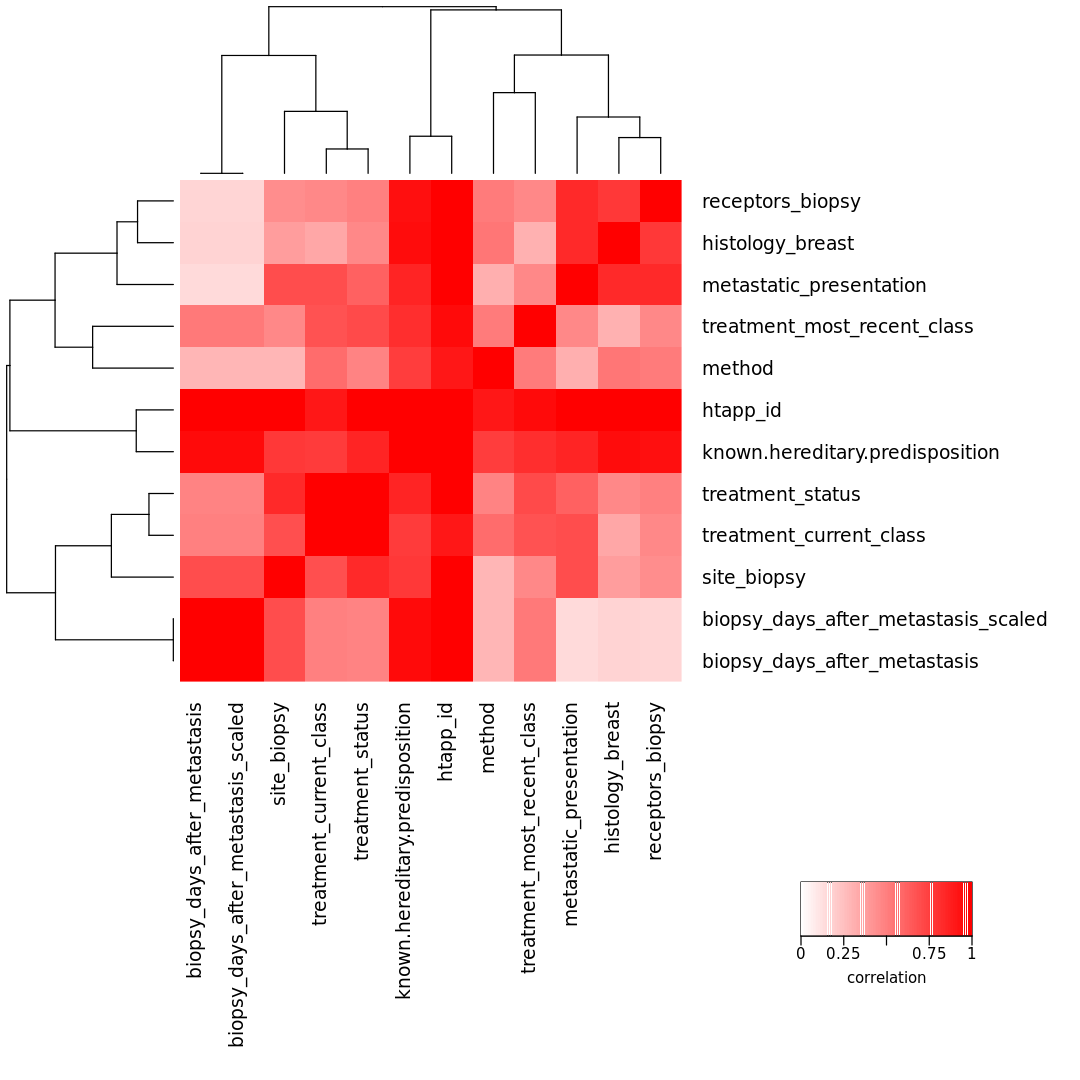

In [11]:
options(repr.plot.width = 9, repr.plot.height =9)
form <- ~ method+htapp_id+site_biopsy+receptors_biopsy+metastatic_presentation+biopsy_days_after_metastasis+histology_breast+known.hereditary.predisposition+biopsy_days_after_metastasis_scaled+treatment_status+treatment_current_class+treatment_most_recent_class
# Compute Canonical Correlation Analysis (CCA)
# between all pairs of variables
# returns absolute correlation value
C = canCorPairs( form, annot_df)
# Plot correlation matrix
pdf("feature_cor.pdf",width = 9,height=9)
plotCorrMatrix( C ,margins = c(20,20))
dev.off()
plotCorrMatrix( C ,margins = c(20,20))

### Explain expression variability

In [47]:
#run this if there are connection problems with varPart
#unregister_dopar <- function() {
#  env <- foreach:::.foreachGlobals
#  rm(list=ls(name=env), pos=env)
#}
#unregister_dopar()

In [70]:
#run for compartemnts # all togeter initially run separately
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
for (comp in compartments) {
    print(comp)
    expr=fread(paste0(baseDir,"/PyCache/pseudobulk_counts",comp,".tsv"))
    expr_mat=as.matrix(data.frame(expr,row.names = "V1",check.names = FALSE))
    expr_scale=apply(expr_mat,2,function(x){res=log((x+1)/sum(x+1));return(res)})
    
    include_samples=colnames(expr_mat)[colSums(expr_mat)>0]
    include_samples=include_samples[!include_samples%in%row.names(annot_df[annot_df$receptors_biopsy=="NA",])]
    

    #first gene is used to initialize. For stability use mean across all genes for this purpose.
    expr_scale_mean=t(as.matrix(colMeans(expr_scale)))
    row.names(expr_scale_mean)<-"means"
    expr_scale=rbind(expr_scale_mean,expr_scale)
    form <-  ~ (1|method)+(1|htapp_id)+(1|site_biopsy)+(1|receptors_biopsy)+(1|metastatic_presentation)+(1|histology_breast)+ (1|treatment_most_recent_class)
    
    
    stopifnot(colnames(expr_scale[,include_samples])==row.names(annot_df[include_samples,]))
    
    #suppressing ETA messages (not correctly compiled in jupyter)
    suppressMessages(varPart <- fitExtractVarPartModel(expr_scale[,include_samples], form, annot_df[include_samples,]))
    
    dir.create(run)
    write.table(varPart,paste0(run,"/varPart_expr",comp,".tsv"), sep="\t",quote=F,row.names = T)  
}


[1] "_mal"

Finished...
Total: 2630 s
[1] "_strom"

Finished...
Total: 2759 s


Warning message in dir.create(run):
"'VarPart' already exists"


[1] "_lym"

Finished...
Total: 2591 s


Warning message in dir.create(run):
"'VarPart' already exists"


[1] "_myel"

Finished...
Total: 2537 s


Warning message in dir.create(run):
"'VarPart' already exists"


In [30]:
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
for (comp in compartments){
    varPart=read.table(paste0(run,"/varPart_expr",comp,".tsv"), sep="\t")
    vp <- sortCols( varPart )
    g1=plotPercentBars( vp[c("means","ESR1","PGR","ERBB2"),] )
    g2=plotVarPart( vp )
    
    varPart_long=melt(as.data.table(data.frame(varPart),keep.rownames = TRUE),id.vars = "rn")
    varPart_long[,rank:=rank(-value,ties.method = "random"),by="variable"]
    varPart_long[,topVar:=variable[order(rank)][1],by="rn"]
    g3=ggplot(varPart_long[rn%in%rn[rank<6]],aes(x=rn,y=value,fill=variable))+
    geom_bar(stat="identity",position="stack")+
    facet_wrap(~topVar,scale="free",ncol=4)+
    rotate_labels()+ylab("Variance explained")
    
 
    g4=tableGrob(varPart_long[rn%in%c("ESR1","PGR","ERBB2")])
    g5=tableGrob(varPart_long[variable=="receptors_biopsy"][order(rank)][1:20])
    
    
    pdf(paste0(run,"/varPart",comp,".pdf"),height=8,width=12)
        grid.arrange(
          grobs = list(g1,g2,g3),
          widths = c(2.5, 3),
        heights= c(1,1.5),
          layout_matrix = rbind(c(1, 2),c(3, 3)))
        grid.arrange(
          grobs = list(g4,g5),
          widths = c(1, 1),
          layout_matrix = rbind(c(1, 2)))
    dev.off()    
}

In [12]:
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
vp_list=list()
for (comp in compartments){
    varPart=data.table(read.table(paste0(run,"/varPart_expr",comp,".tsv"), sep="\t"),keep.rownames = "gene")
    vp_long=melt(varPart,id.vars = "gene")  
    vp_long[,compartment:=comp,]
    vp_list[[comp]]=vp_long    
    }
vp_combined=rbindlist(vp_list)

In [13]:
vp_combined[,median_ve:=median(value),by=c("variable","compartment")]
vp_combined[,variable:=factor(variable,levels=unique(variable[order(median_ve,decreasing=T)])),]
vp_combined[,compartment:=factor(compartment,levels=c("_mal","_strom","_lym","_myel")),]

In [23]:
vp_combined[,rank:=rank(-value,ties.method = 'random'),by=c('compartment','variable')]
vp_combined[,annot:=ifelse(rank<=5,gene,NA),by=c('compartment','variable')]

In [54]:
vp_combined[,variable:=factor(variable,levels=c('htapp_id','method','site_biopsy','treatment_most_recent_class','histology_breast','receptors_biopsy','metastatic_presentation','Residuals')),]

Warning message:
"Removed 849088 rows containing missing values (geom_text)."


png 
  2

Warning message:
"Removed 849088 rows containing missing values (geom_text)."


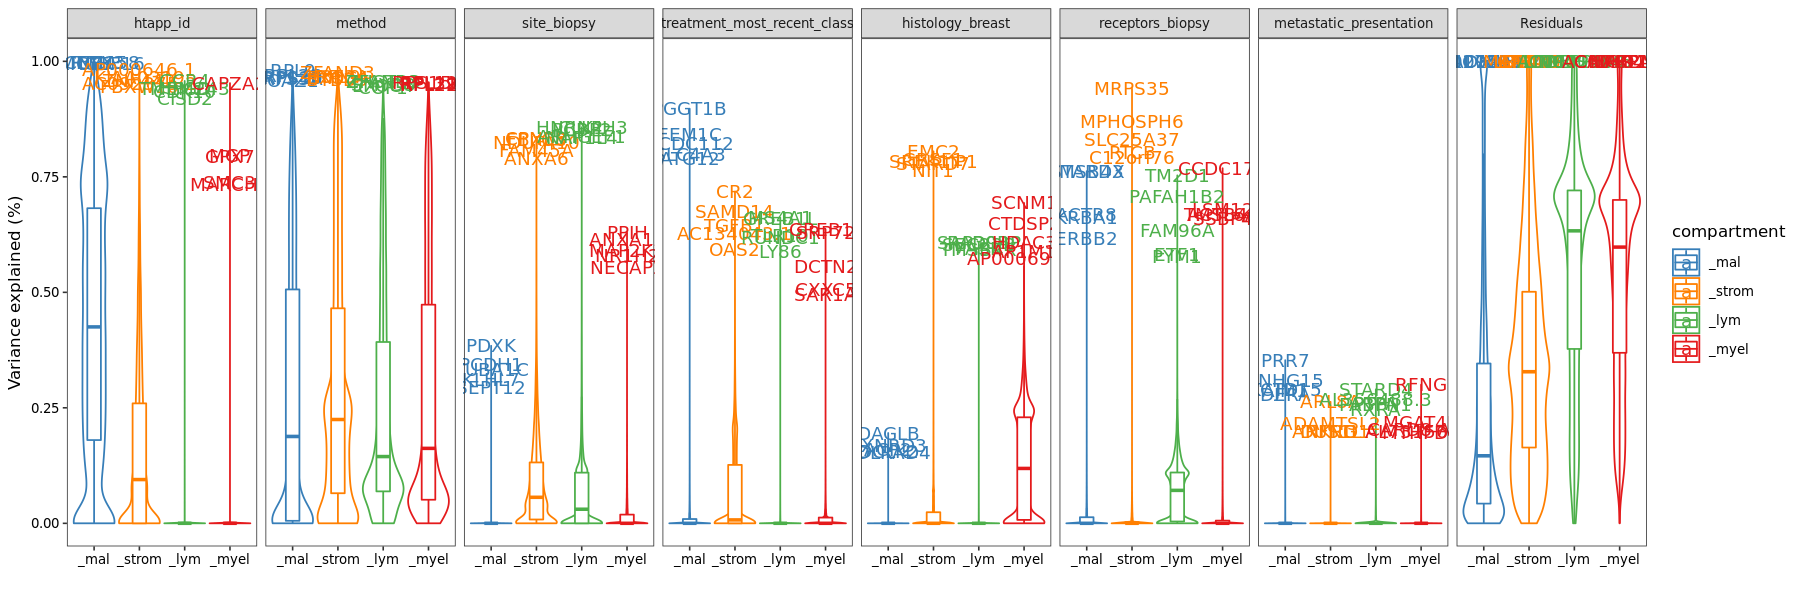

In [55]:
options(repr.plot.width = 15, repr.plot.height =5)
pl=ggplot(vp_combined,aes(x=compartment,y=value,col=compartment))+geom_violin(scale = "width")+
geom_boxplot(outlier.size = -1,width=0.3,position = position_dodge(width = 1))+geom_text(aes(label=annot))+
scale_color_manual(values = c("#377EB8", "#FF7F00", "#4DAF4A", "#E41A1C"))+facet_wrap(~variable,nrow=1)+
ylab("Variance explained (%)")+xlab("")
pdf(paste0(run,"/varPart_all_compartments.pdf"),height=5,width=15)
pl
dev.off()
pl

Warning message:
"Removed 849088 rows containing missing values (geom_text)."


png 
  2

Warning message:
"Removed 849088 rows containing missing values (geom_text)."


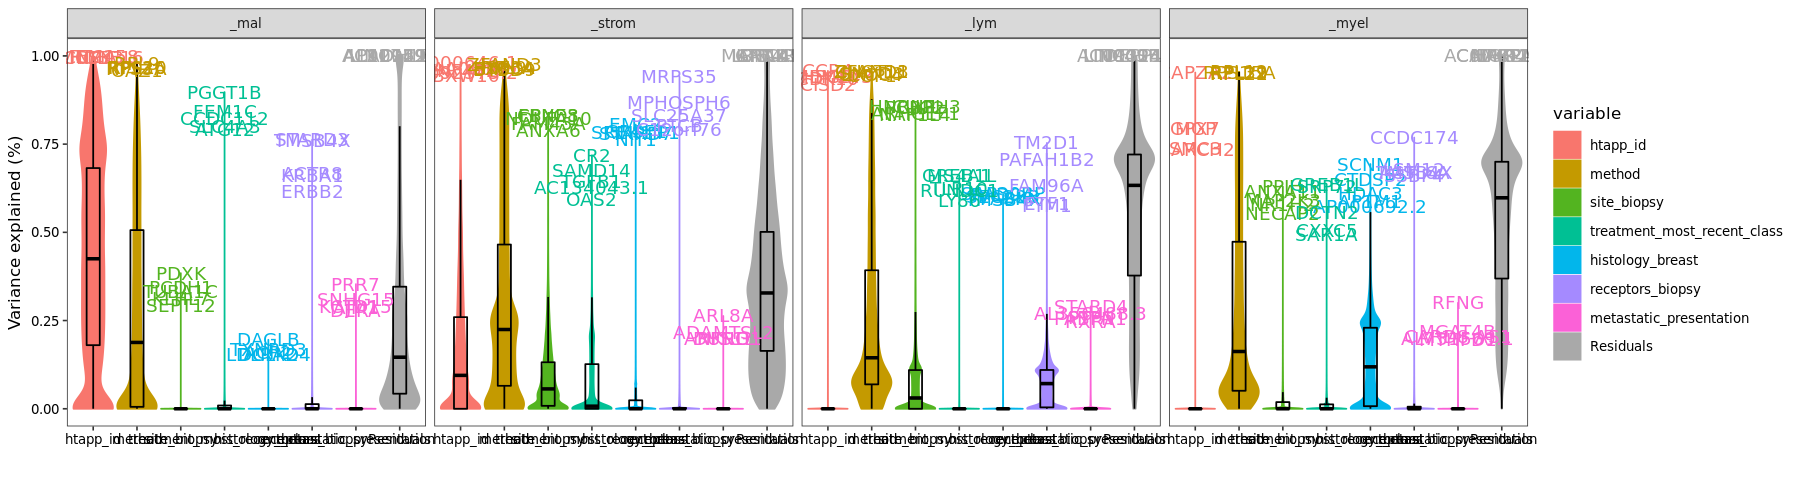

In [100]:
var_colors=c("Residuals"="dark grey","htapp_id"="#F8766D", "method"="#C49A00", "site_biopsy"="#53b420", 
                           "treatment_most_recent_class"="#00c094","histology_breast"="#02b6eb", "metastatic_presentation"="#FB61D7", 
                           "receptors_biopsy"="#A58AFF")
options(repr.plot.width = 15, repr.plot.height =4)
pl=ggplot(vp_combined,aes(x=variable,y=value,fill=variable,col=variable))+geom_violin(scale = "width")+
geom_boxplot(outlier.size = -1,width=0.3,position = position_dodge(width = 1),fill='transparent',color='black')+geom_text(aes(label=annot))+
facet_wrap(~compartment,nrow=1)+ylab("Variance explained (%)")+xlab("")+
scale_fill_manual(values=var_colors)+
scale_color_manual(values=var_colors)
pdf(paste0(run,"/varPart_all_compartments_grouped.pdf"),height=4,width=15)
pl
dev.off()
pl

In [103]:
summary(vp_combined[,.N,by=c('variable','compartment')])

                        variable compartment       N        
 htapp_id                   :4   _mal  :8    Min.   :26539  
 method                     :4   _strom:8    1st Qu.:26539  
 site_biopsy                :4   _lym  :8    Median :26539  
 treatment_most_recent_class:4   _myel :8    Mean   :26539  
 histology_breast           :4               3rd Qu.:26539  
 receptors_biopsy           :4               Max.   :26539  
 (Other)                    :8                              

In [30]:
vp_combined[(variable=='receptors_biopsy')&(compartment=='_mal')][order(value,decreasing=TRUE),][1:40]$gene[1:37]

[1] "STARD3"    "TMSB4X"    "ACTR8"     "KRBA1"     "ERBB2"     "GRB7"     
 [7] "C3orf38"   "C3orf14"   "ZKSCAN1"   "RPAP3"     "PGR"       "TNFAIP8L1"
[13] "ATRIP"     "VAMP5"     "LINC00662" "MZF1-AS1"  "MDM1"      "MIEN1"    
[19] "MKKS"      "DALRD3"    "BECN1"     "ASB13"     "SAMD15"    "CCDC74B"  
[25] "C5AR2"     "XPC"       "REC8"      "RRM2B"     "MTA2"      "BDP1"     
[31] "ARIH2"     "ERICH3"    "LASP1"     "C15orf39"  "SLX4IP"    "NEUROD2"  
[37] "ESR1"

png 
  2

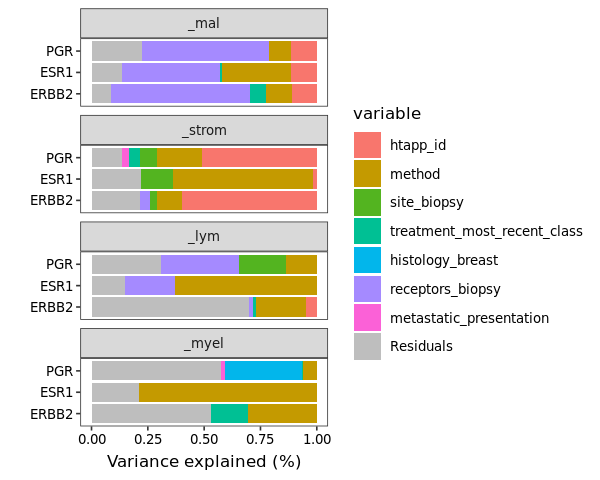

In [59]:
options(repr.plot.width = 5, repr.plot.height =4)
pl=ggplot(vp_combined[gene%in%c("ESR1","PGR","ERBB2")],aes(y=value,x=gene,fill=variable))+
geom_bar(stat="identity")+
facet_wrap(~compartment,ncol=1)+
scale_fill_manual(values=c("Residuals"="grey","htapp_id"="#F8766D", "method"="#C49A00", "site_biopsy"="#53b420", 
                           "treatment_most_recent_class"="#00c094","histology_breast"="#02b6eb", "metastatic_presentation"="#FB61D7", 
                           "receptors_biopsy"="#A58AFF"))+
coord_flip()+ylab("Variance explained (%)")+xlab("")
pdf(paste0(run,"/varPart_receptors_all_compartments.pdf"),height=4,width=5)
pl
dev.off()
pl

#### Assess variance explained with pca

In [88]:
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
comp=compartments[1]
varPart=read.table(paste0(run,"/varPart_expr",comp,".tsv"), sep="\t")

In [89]:
pca=princomp(varPart[varPart$Residuals<0.4&varPart$htapp_id<0.4&varPart$method<0.4,!names(varPart) %in% c("Residuals")])

In [90]:
summary(pca)

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     0.1843723 0.1408164 0.09468999 0.06281998 0.04204873
Proportion of Variance 0.4936629 0.2879688 0.13021083 0.05731054 0.02567702
Cumulative Proportion  0.4936629 0.7816317 0.91184255 0.96915308 0.99483010
                            Comp.6       Comp.7
Standard deviation     0.017833184 0.0061621317
Proportion of Variance 0.004618455 0.0005514433
Cumulative Proportion  0.999448557 1.0000000000

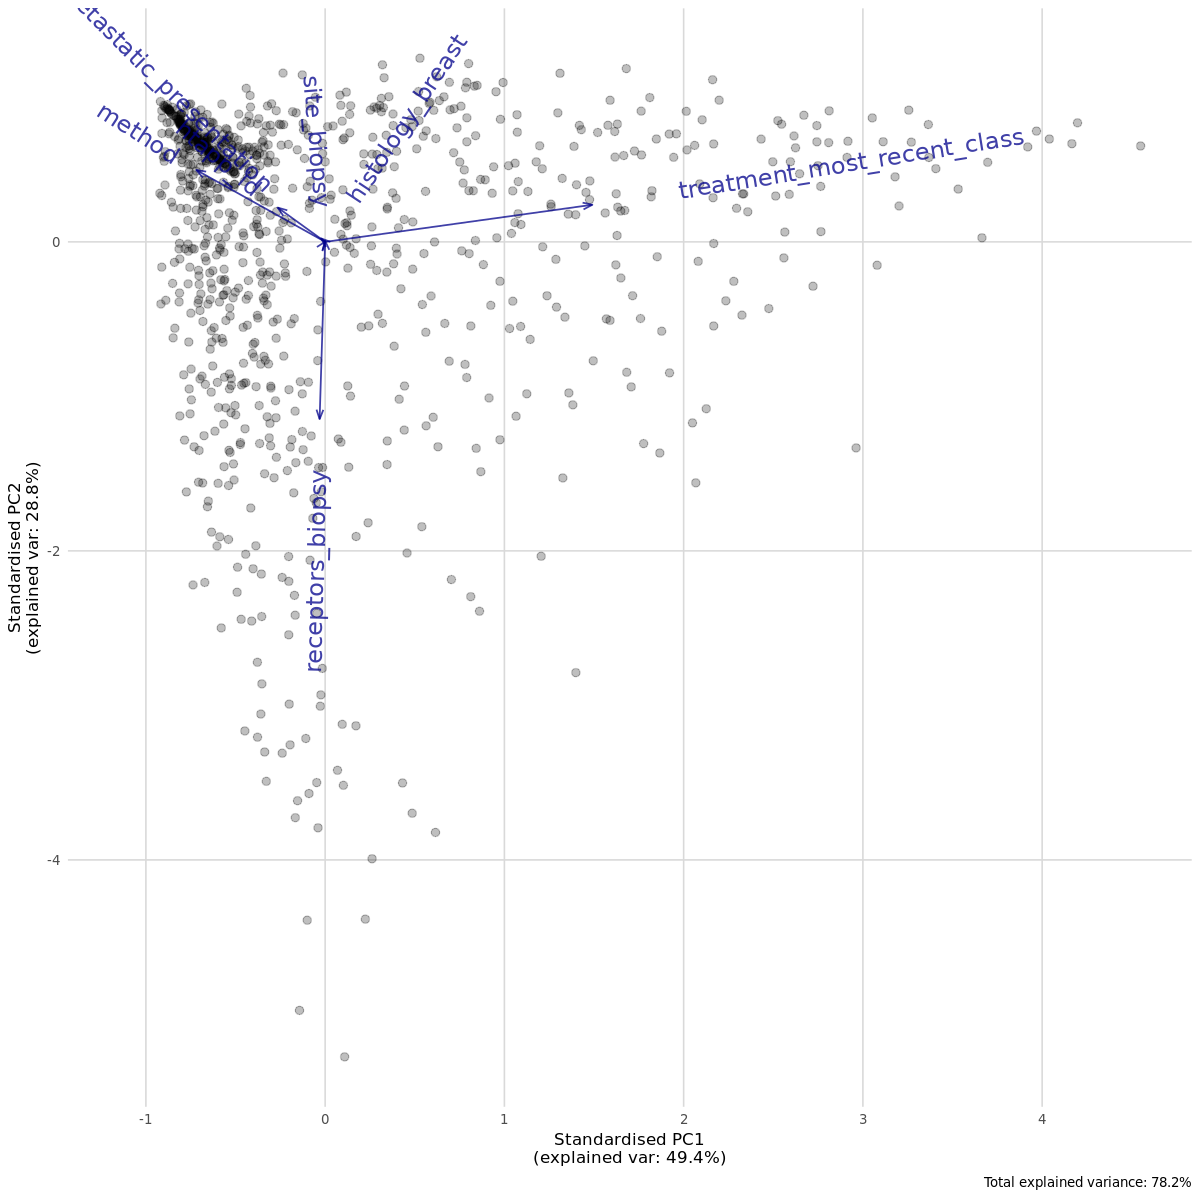

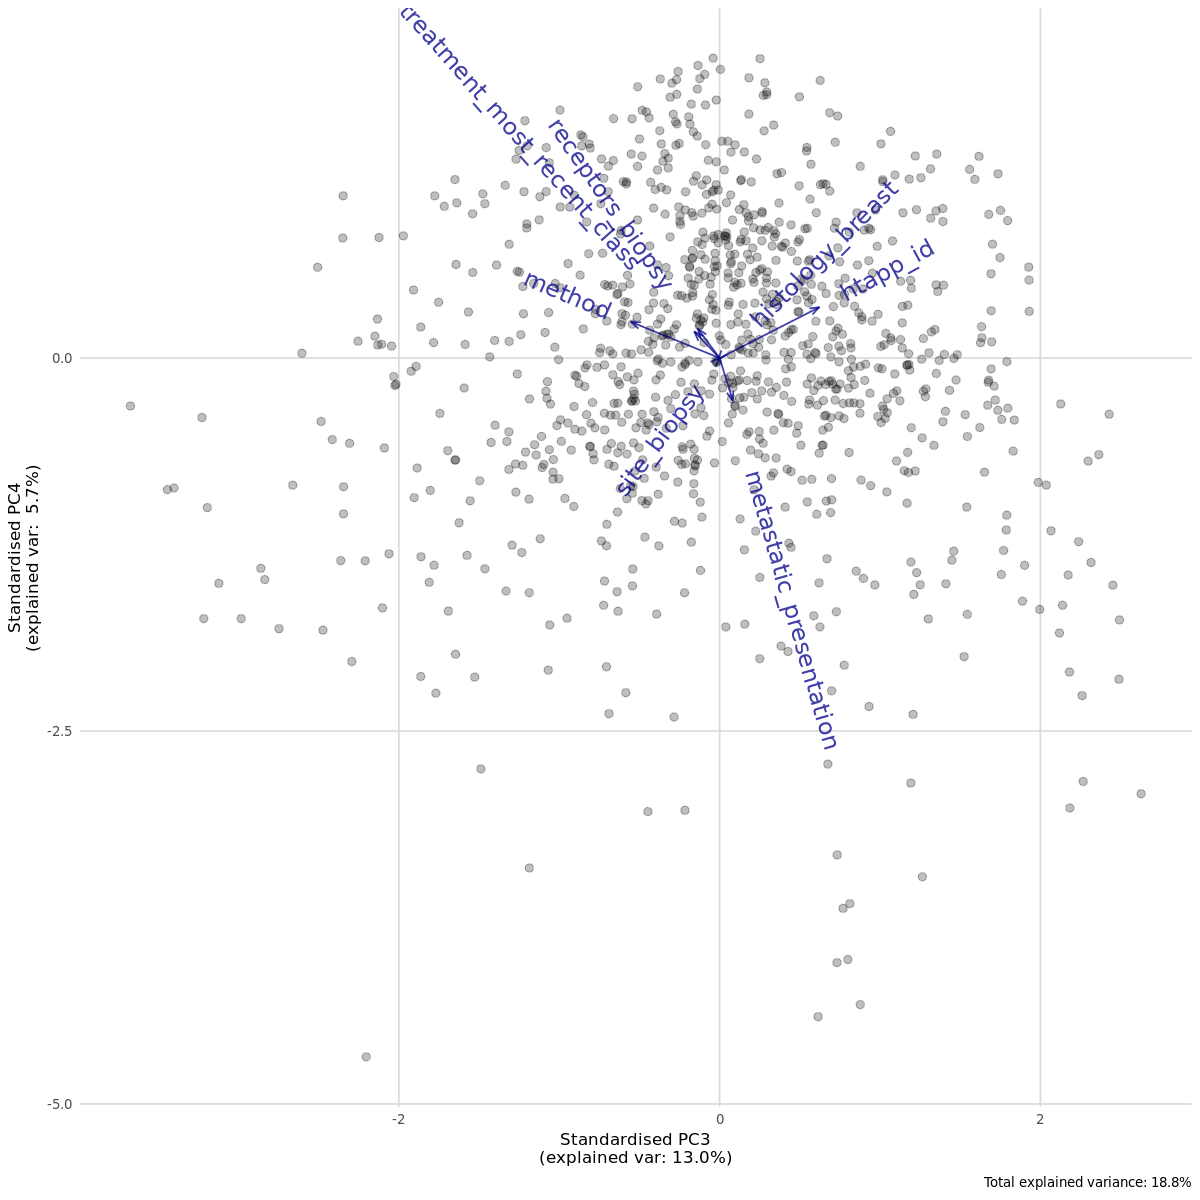

In [91]:
options(repr.plot.width = 10, repr.plot.height =10)
ggplot_pca(pca,choices = c(1,2),arrows_textsize = 5)
ggplot_pca(pca,choices = c(3,4),arrows_textsize = 5)

#### Look into genes

In [92]:
plot_expr <-function(comp,gene,var){
    expr=fread(paste0(baseDir,"/PyCache/pseudobulk_counts_",comp,".tsv"))
    expr_mat=as.matrix(data.frame(expr,row.names = "V1",check.names = FALSE))
    expr_cpm=log2(apply(expr_mat,2,function(x){res=x/sum(x)*10^6;return(res)})+1)
    include_samples=colnames(expr_mat)[colSums(expr_mat)>0]
    stopifnot(colnames(expr_cpm[,include_samples])==row.names(annot_df[include_samples,]))

    GE <- data.frame( log2_cpm = expr_cpm[gene,include_samples], var = annot_df[include_samples,var])
    plotStratify( log2_cpm ~ var, GE, main=gene)    
}



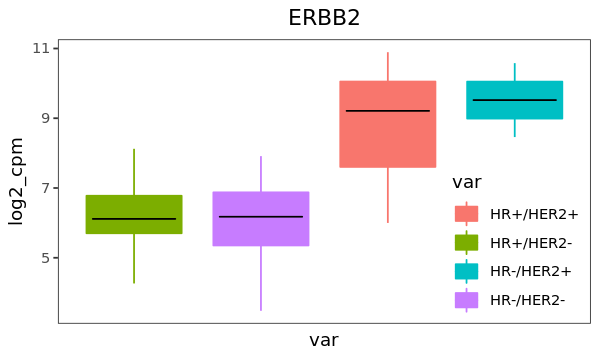

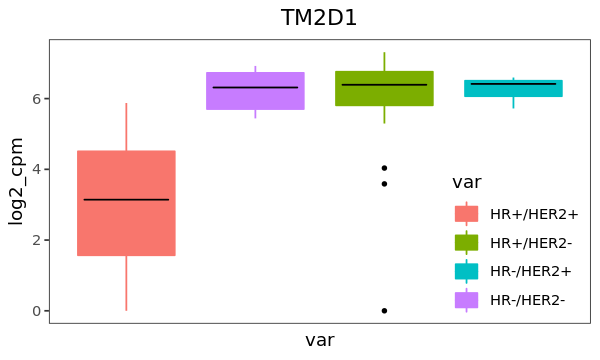

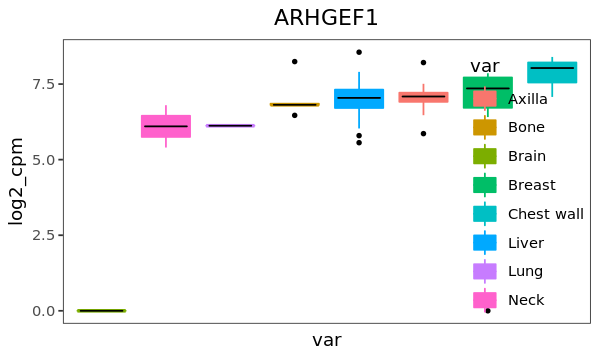

In [93]:
options(repr.plot.width = 5, repr.plot.height =3)
plot_expr("mal","ERBB2","receptors_biopsy_simpl")
plot_expr("lym","TM2D1","receptors_biopsy_simpl")
plot_expr("lym","ARHGEF1","site_biopsy")

### (Hierarchical) clustering of samples based on pseudobulk

In [3]:
comp="_mal"
expr_df=read.table(paste0(baseDir,"/PyCache/pseudobulk_counts",comp,".tsv"),row.names = 1,check.names = FALSE,)

In [12]:
#exclude samples with a low number of malignant cells
exclude_smp=c("HTAPP-232-SMP-6759","HTAPP-586-SMP-8599","HTAPP-414-SMP-1681","HTAPP-330-SMP-1082","HTAPP-382-SMP-1441","HTAPP-364-SMP-1321")
#exclude samples with no malignant cells
include_samples=colnames(expr_df)[colSums(expr_df)>0]
#exclude samples with no receptor annotation
include_samples=include_samples[!include_samples%in%c(row.names(annot_df[annot_df$receptors_biopsy=="NA",]),exclude_smp)]

In [13]:
expr_mat=as.matrix(expr_df[,include_samples])
expr_scale=apply(expr_mat,2,function(x){res=log((x+1)/sum(x+1));return(res)})

In [14]:
annot_filt=annot_df[colnames(expr_mat),c("method","receptors_biopsy","receptors_biopsy_simpl","site_biopsy","mode","PAM50.subtype_sc"),]

In [15]:
mod = model.matrix(~as.factor(receptors_biopsy_simpl)+as.factor(site_biopsy), data=annot_filt)

In [16]:
comb=ComBat(expr_scale,annot_filt$method,mod = mod)

Found2batches

Adjusting for10covariate(s) or covariate level(s)



Standardizing Data across genes


Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [70]:
comb[1:5,1:5]

,HTAPP-225-SMP-6756,HTAPP-589-SMP-2851,HTAPP-231-SMP-6758,HTAPP-862-SMP-7059,HTAPP-862-SMP-7060
AL627309.1,-12.65326,-12.87041,-12.98907,-12.20202,-12.19633
AL732372.1,-14.40704,-14.36024,-15.87703,-17.47404,-17.17196
AC114498.1,-15.92713,-15.03035,-15.25138,-15.82274,-17.36285
AL669831.2,-14.98162,-16.88715,-17.61148,-17.95146,-16.88998
AL669831.5,-10.28872,-10.80087,-11.21089,-11.07054,-10.77327


In [18]:
des=annot_filt
des$ID=row.names(des)

In [19]:
feat_filt=featurefilter(comb,percentile = 0.4)

***feature filter function***

extracting the most variable: 0.4 percent

features to start with: 26538

performing calculations for median absolute deviation

printing topN most variable features with statistics...



              feature      mean       var       sd      MAD
CALML5         CALML5 -12.01863 13.812813 3.716559 5.450817
SCGB2A2       SCGB2A2 -11.02611 16.195248 4.024332 5.373387
TFAP2B         TFAP2B -12.03794 11.597676 3.405536 4.820780
TFF1             TFF1 -11.87571 11.042686 3.323054 4.151364
KCNJ3           KCNJ3 -12.78374 12.133109 3.483261 3.999078
AC093001.1 AC093001.1 -11.88414  9.776913 3.126806 3.930602
NOVA1           NOVA1 -11.83992  8.476996 2.911528 3.885771
LINC01087   LINC01087 -12.74354  8.838471 2.972957 3.774253
MUC15           MUC15 -13.97222  6.868135 2.620713 3.756734
LRP2             LRP2 -11.22843  6.027680 2.455133 3.755481
PCSK1N         PCSK1N -12.51613  8.990972 2.998495 3.697476
LTF               LTF -12.56351  9.651128 3.106626 3.686247
GP2               GP2 -13.43653  6.755967 2.599224 3.655983
LY6K             LY6K -13.68726  6.422267 2.534219 3.610151
PEG10           PEG10 -12.61812  7.406670 2.721520 3.597711
ANKRD30B     ANKRD30B -11.11724  6.72649

features remaining: 107



***M3C***

method: Monte Carlo simulation

clustering algorithm: hc

annotation: yes

running simulations...



  |======================================================================| 100%


done.

running consensus cluster algorithm for real data...

done.



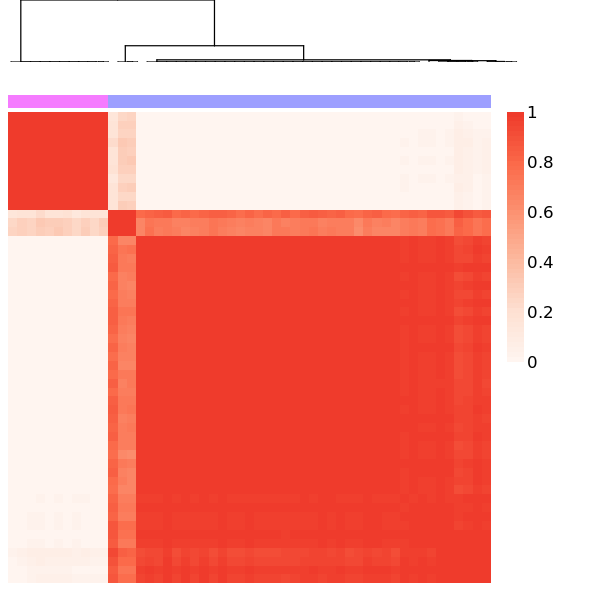

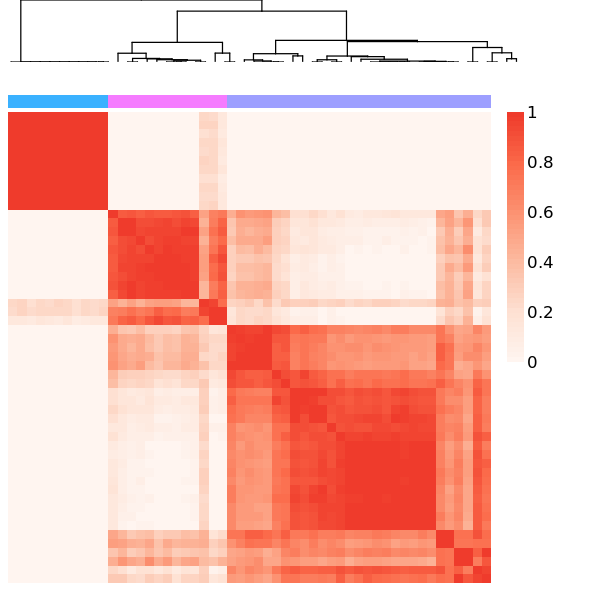

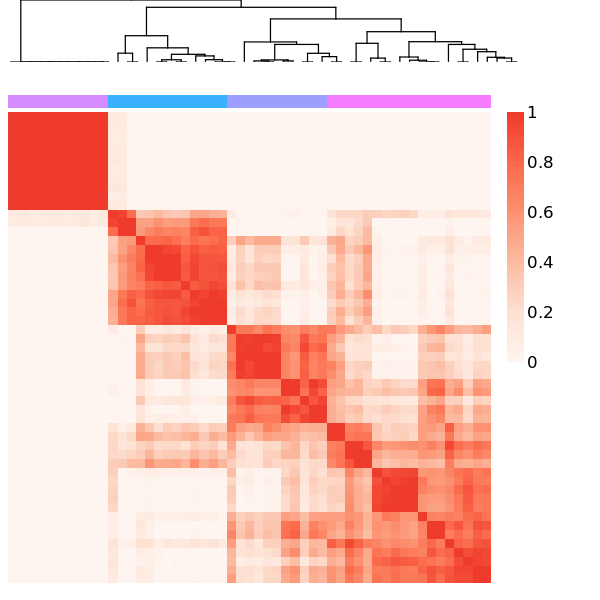

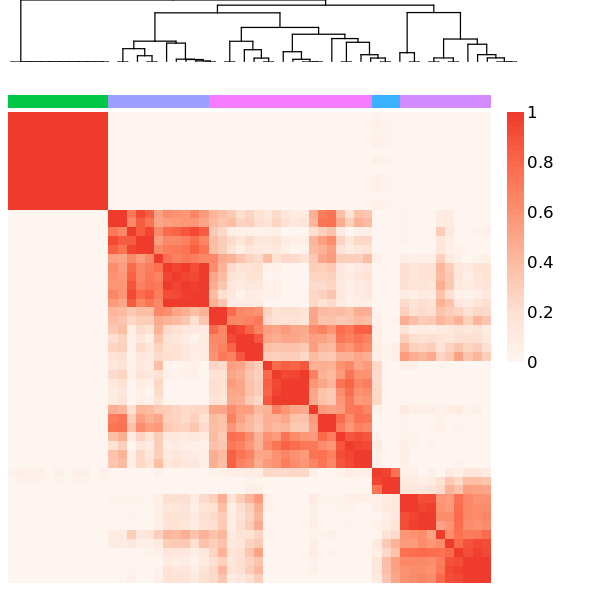

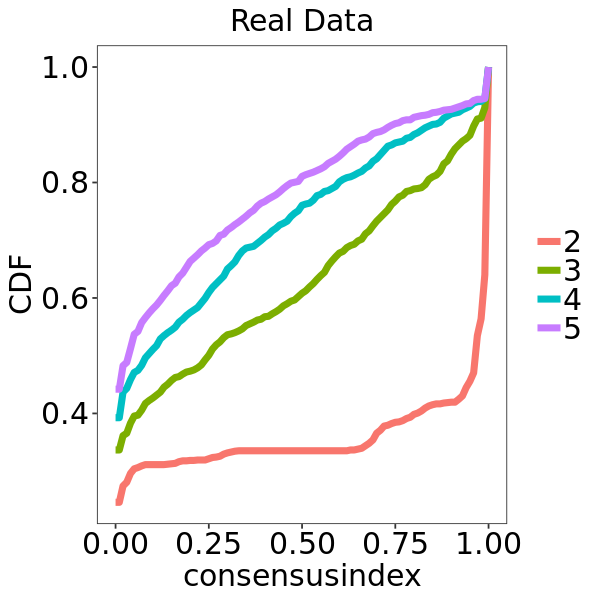

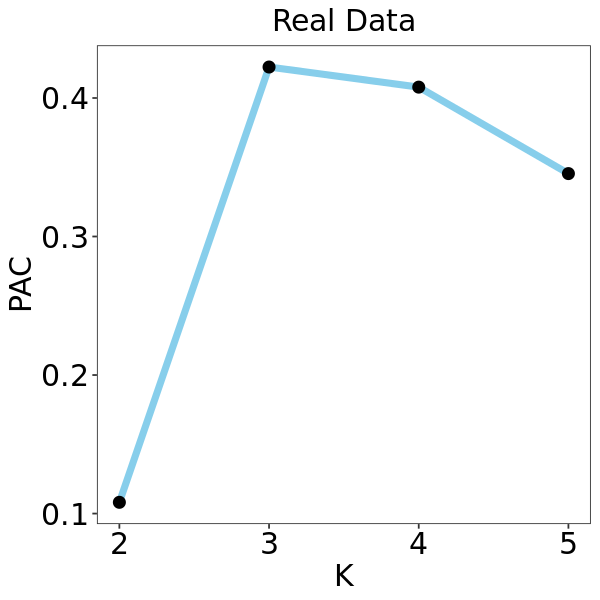

optimal K: 2



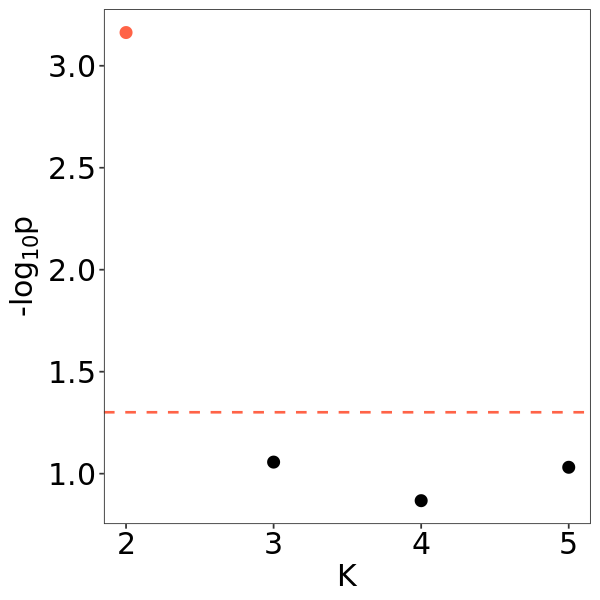

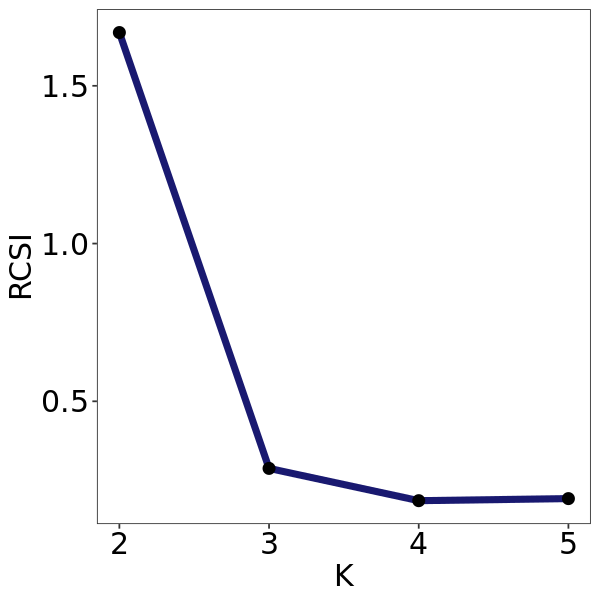

In [21]:
options(repr.plot.width = 5, repr.plot.height =5)
res <- M3C(feat_filt$filtered_data, des = des ,clusteralg = "hc",maxK = 5,showheatmaps = TRUE, iters=25)

In [22]:
m3c_cl=res$realdataresults[[2]]$ordered_annotation
row.names(m3c_cl)=gsub("\\.","-",row.names(m3c_cl))

In [23]:
m3c_cl$pat=gsub("-SMP.*","",row.names(m3c_cl))
m3c_cl[!m3c_cl$pat%in%m3c_cl$pat[duplicated(m3c_cl$pat)],]$pat<-"ND"

In [24]:
cols=list(pat=c("HTAPP-223"="green","HTAPP-262"="red","HTAPP-862"="blue","HTAPP-887"="yellow","ND"="black"),         
receptors_biopsy=c("ER+/PR+/HER2+"="darkblue","ER+/PR+/HER2-"="blue","ER+/PR-/HER2+"="cornflowerblue","ER+/PR-/HER2-"="deepskyblue","ER-/PR-/HER2+"="darkgreen","ER-/PR-/HER2-"="darkolivegreen1"),
         receptors_biopsy_simpl=unlist(rc_colors),
         mode=c("V2"="grey","V3"="black"),
         method= c("snRNAseq"="grey","scRNAseq"="black"),
        site_biopsy=unlist(ti_colors),
         PAM50.subtype_sc=c("Basal"="darkolivegreen1","Her2"="darkgreen","LumA"="darkblue","LumB"="lightblue"))

In [25]:
#cols=list(pat=c("HTAPP-223"="green","HTAPP-262"="red","HTAPP-862"="blue","HTAPP-887"="yellow","ND"="black"),         
#receptors_biopsy=c("ER+/PR+/HER2+"="darkblue","ER+/PR+/HER2-"="blue","ER+/PR-/HER2+"="cornflowerblue","ER+/PR-/HER2-"="deepskyblue","ER-/PR-/HER2+"="darkgreen","ER-/PR-/HER2-"="darkolivegreen1"),
#         receptors_biopsy_simpl=c("HR+/HER2+"="darkblue","HR+/HER2-"="lightblue","HR-/HER2+"="darkgreen","HR-/HER2-"="darkolivegreen1"),
#         mode=c("V2"="grey","V3"="black"),
#         method= c("snRNAseq"="grey","scRNAseq"="black"),
#         PAM50.subtype_sc=c("Basal"="darkolivegreen1","Her2"="darkgreen","LumA"="darkblue","LumB"="lightblue"))

In [77]:
pca=prcomp(t(feat_filt$filtered_data))

In [78]:
sel_rot=names(sort(sqrt(pca$rotation[,c("PC1")]^2+pca$rotation[,c("PC2")]^2),decreasing=TRUE)[1:30])

In [79]:
pca_red=pca
pca_red$rotation=pca_red$rotation[sel_rot,]

png 
  2

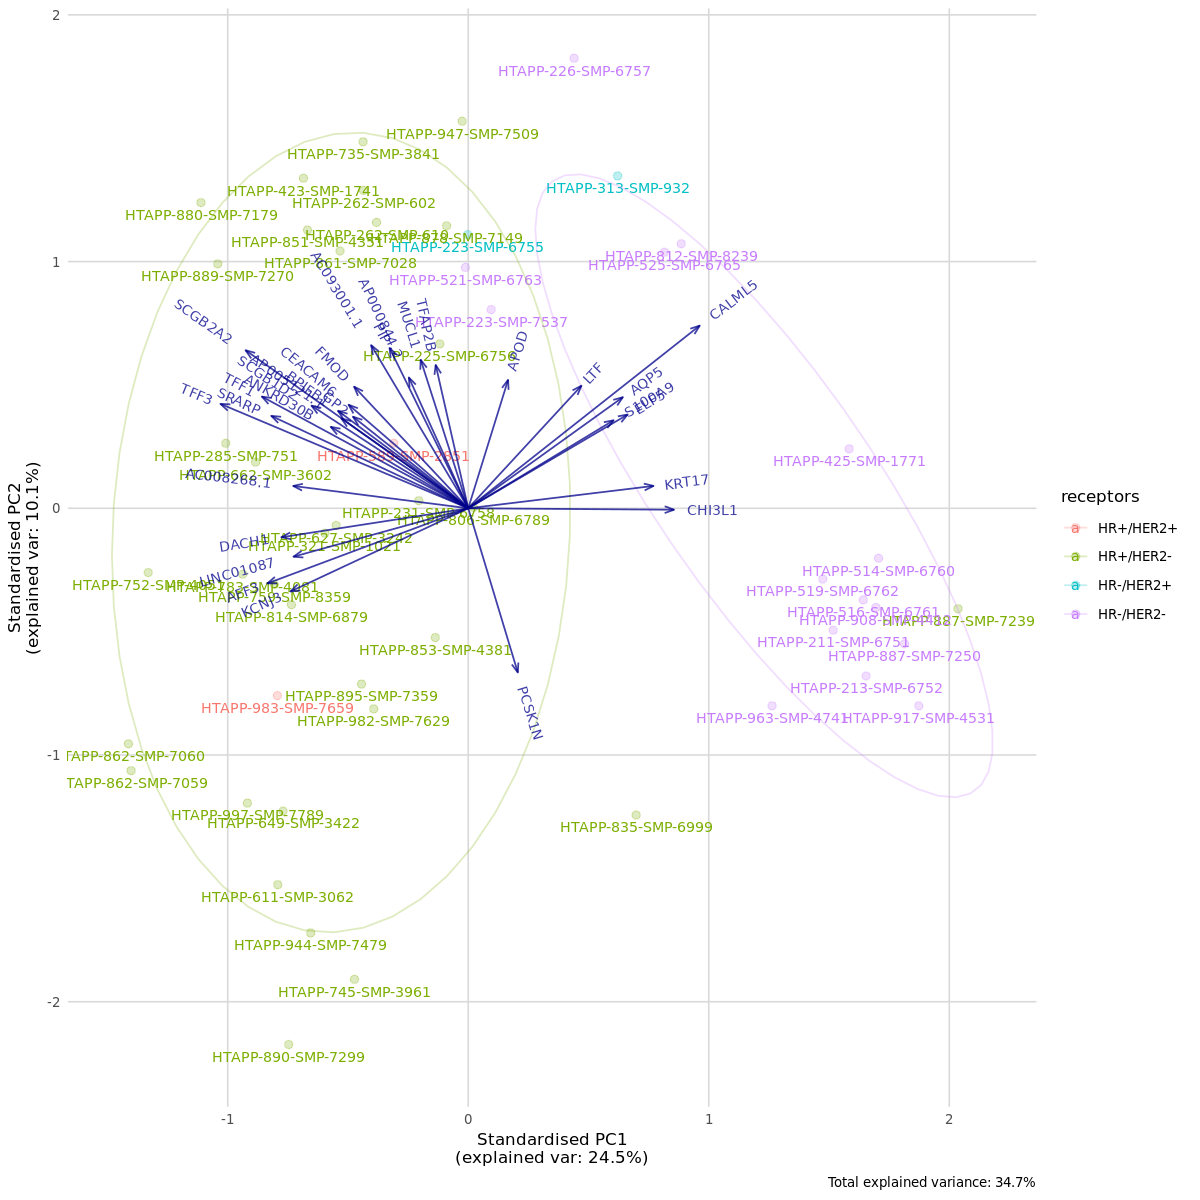

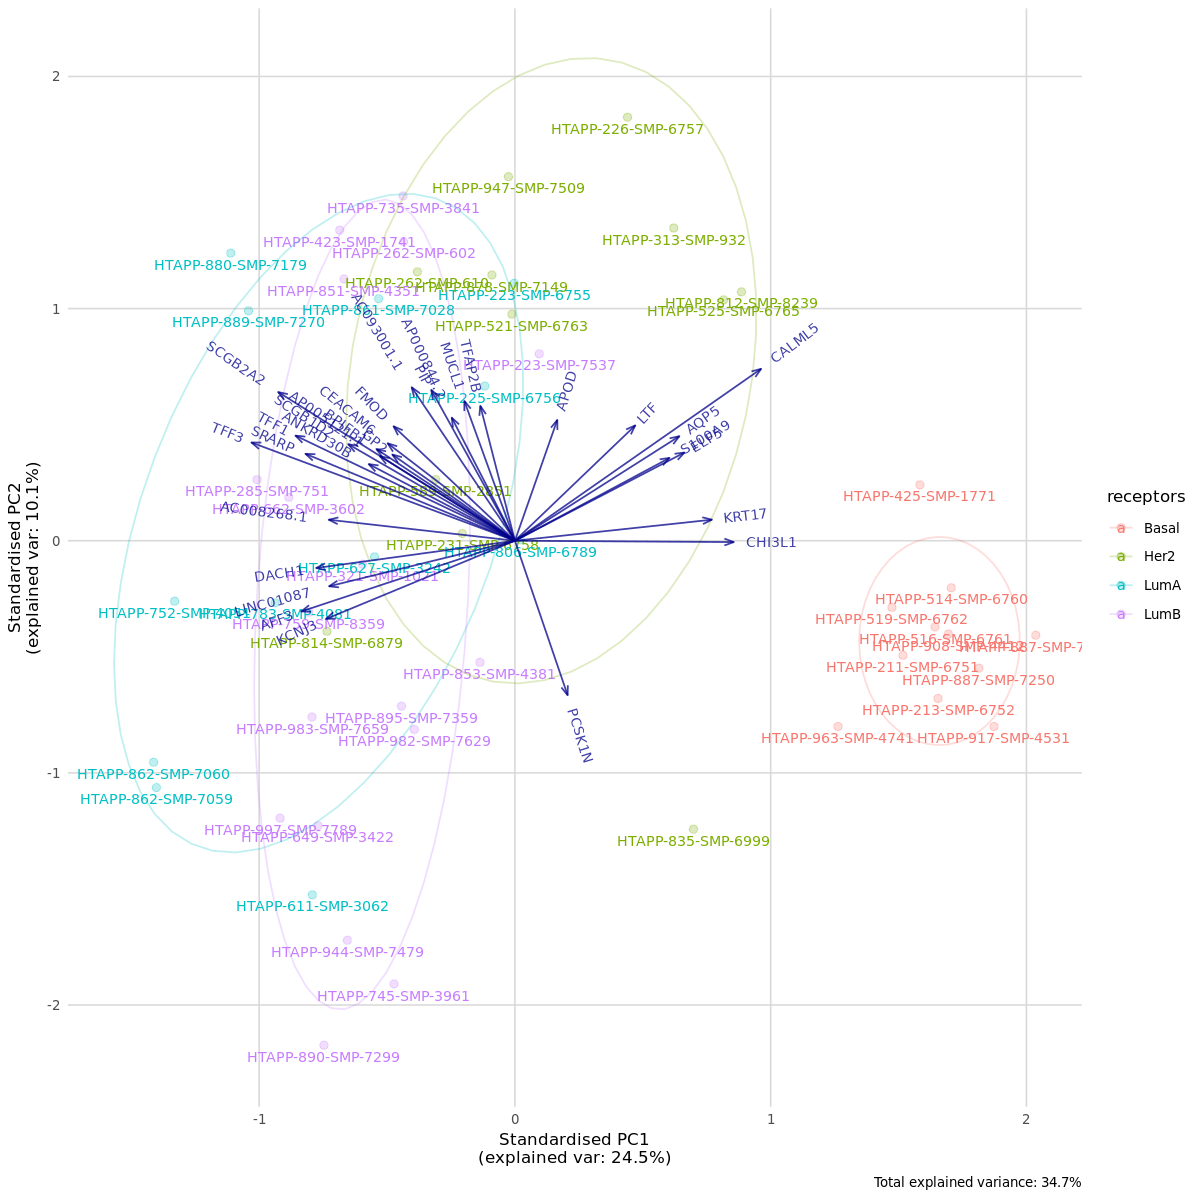

In [29]:
options(repr.plot.width = 10, repr.plot.height =10)
group_name="receptors"
pl1=ggplot_pca(pca_red,labels =row.names(pca_red$x),groups=annot_filt[row.names(pca_red$x),]$receptors_biopsy_simpl)
pl2=ggplot_pca(pca_red,labels =row.names(pca_red$x),groups=annot_filt[row.names(pca_red$x),]$PAM50.subtype_sc)

pdf("mal_pseudobulk_pca.pdf",width = 10,height = 10)
pl1
pl2
dev.off()
pl1
pl2

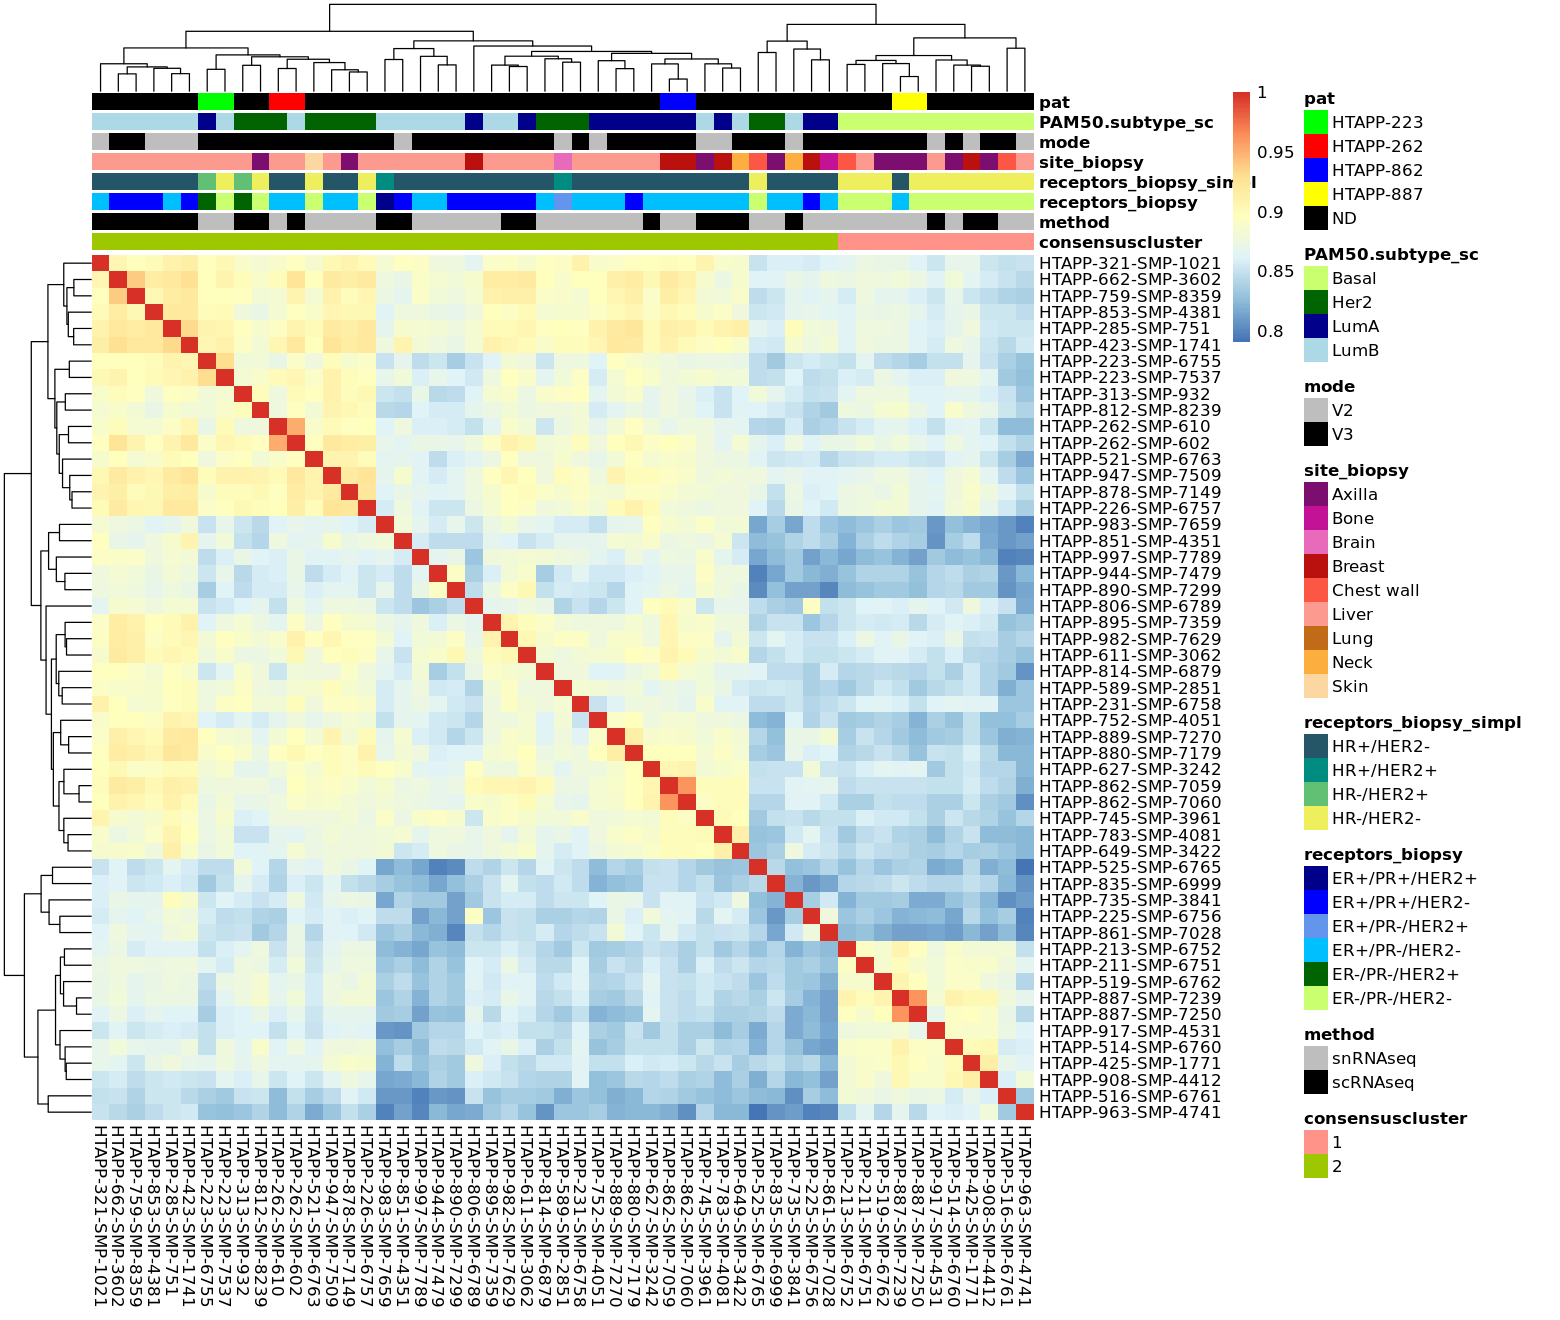

In [33]:
#using all genes
options(repr.plot.width = 13, repr.plot.height =11)
cors=cor(comb)
pheatmap(cors,annotation_col = m3c_cl,annotation_colors = cols)

png 
  2

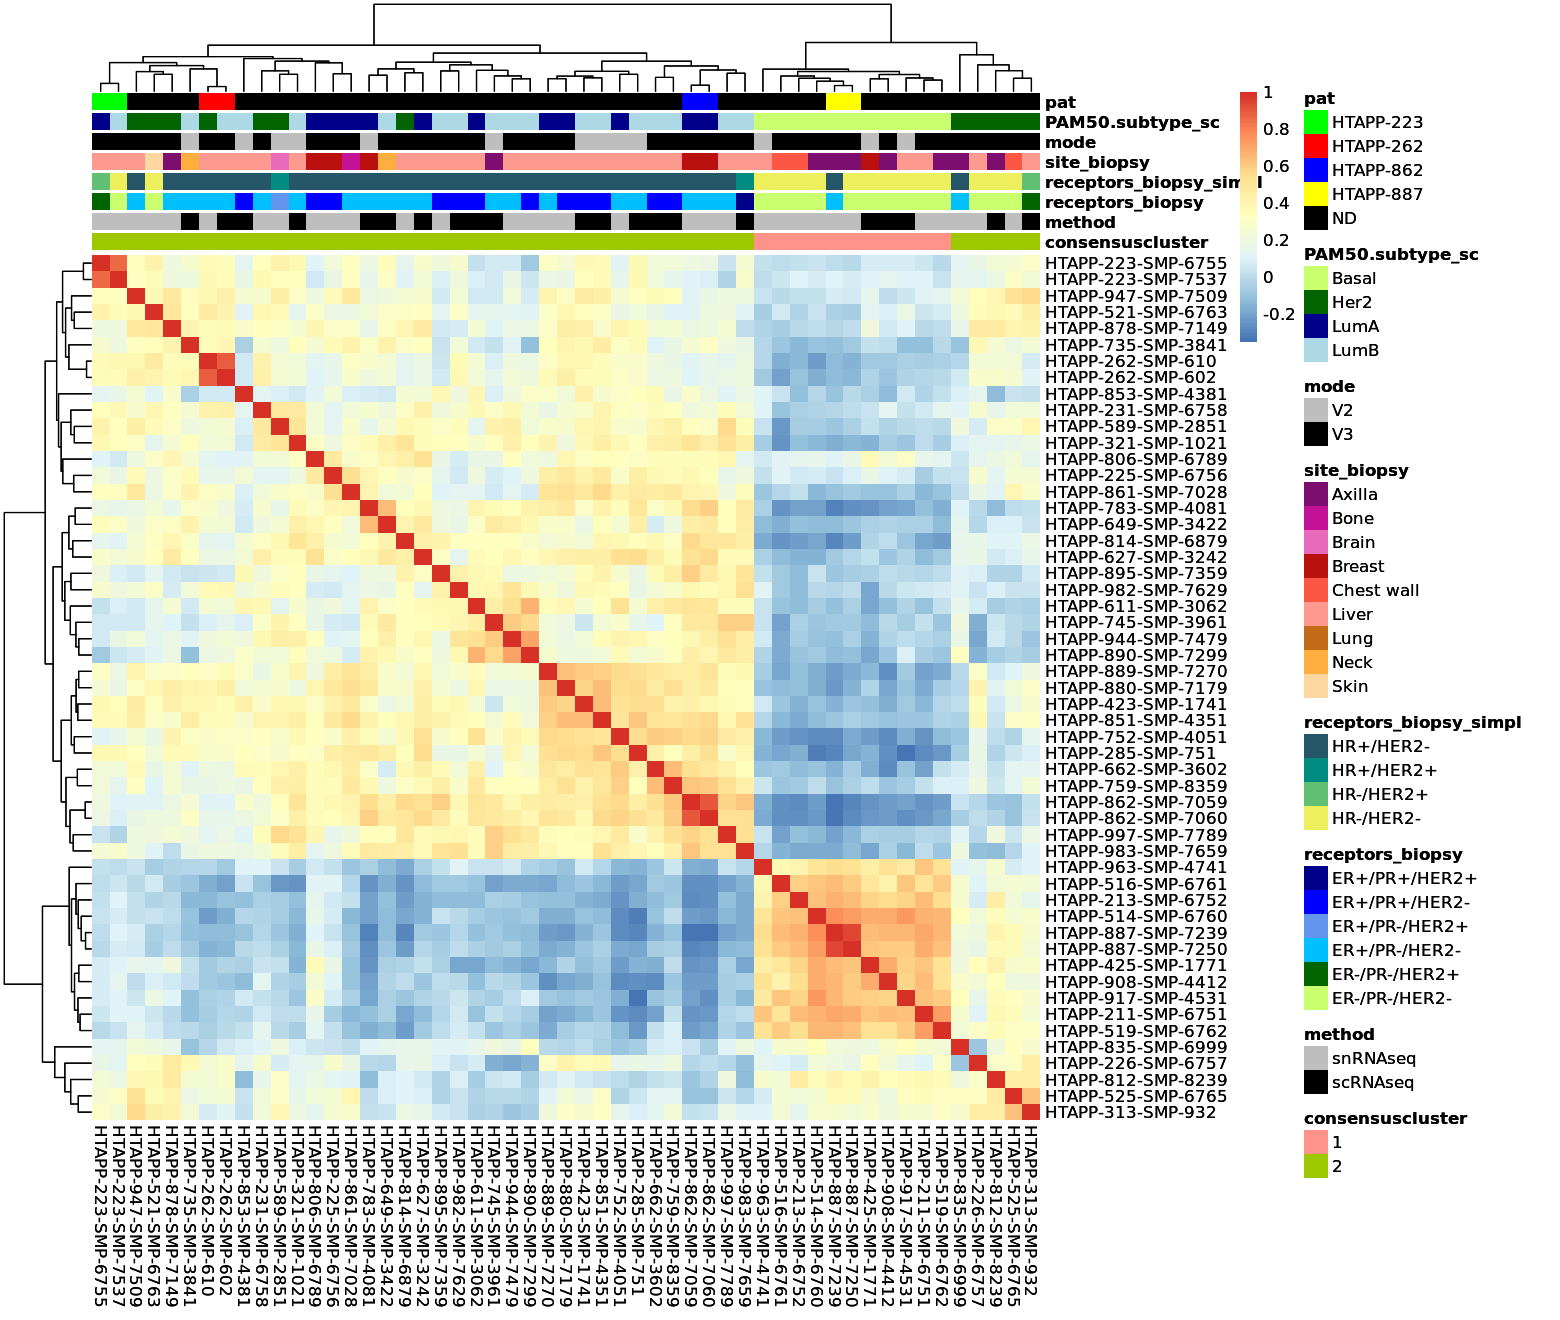

In [34]:
#variable genes
options(repr.plot.width = 13, repr.plot.height =11)
cors=cor(feat_filt$filtered_data)
pl=pheatmap(cors,annotation_col = m3c_cl,annotation_colors = cols)
pdf("cor_heatmap_var_genes.pdf",width = 13,height=11)
print(pl)
dev.off()
pl

In [1]:
#test association of the two clusters with representation of liver and axilla biopsies, respectively
liver <-
  matrix(c(25, 5,37-25, 16-5),
         nrow = 2,
         dimnames = list(cl = c("c1", "c2"),
                         is = c("yes", "no")))
fisher.test(liver, alternative = "two.sided")

axilla <-
  matrix(c(1, 7,37-1, 16-7),
         nrow = 2,
         dimnames = list(cl = c("c1", "c2"),
                         is = c("yes", "no")))
fisher.test(axilla, alternative = "two.sided")



	Fisher's Exact Test for Count Data

data:  liver
p-value = 0.01854
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.117713 20.300421
sample estimates:
odds ratio 
  4.441319 



	Fisher's Exact Test for Count Data

data:  axilla
p-value = 0.0004921
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.0007784153 0.3587055580
sample estimates:
odds ratio 
0.03876271 


In [48]:
res_all

Var1,Var2,value,group,annot,pat1,pat2,comb
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
HTAPP-917-SMP-4531,HTAPP-908-SMP-4412,0.5706899,Basal,PAM50.subtype_sc,HTAPP-917,HTAPP-908,1_2
HTAPP-425-SMP-1771,HTAPP-908-SMP-4412,0.6868515,Basal,PAM50.subtype_sc,HTAPP-425,HTAPP-908,1_3
HTAPP-519-SMP-6762,HTAPP-908-SMP-4412,0.5230195,Basal,PAM50.subtype_sc,HTAPP-519,HTAPP-908,1_4
HTAPP-211-SMP-6751,HTAPP-908-SMP-4412,0.6400449,Basal,PAM50.subtype_sc,HTAPP-211,HTAPP-908,1_5
HTAPP-213-SMP-6752,HTAPP-908-SMP-4412,0.5531339,Basal,PAM50.subtype_sc,HTAPP-213,HTAPP-908,1_6
HTAPP-887-SMP-7250,HTAPP-908-SMP-4412,0.6032931,Basal,PAM50.subtype_sc,HTAPP-887,HTAPP-908,1_7
HTAPP-887-SMP-7239,HTAPP-908-SMP-4412,0.6539869,Basal,PAM50.subtype_sc,HTAPP-887,HTAPP-908,1_8
HTAPP-963-SMP-4741,HTAPP-908-SMP-4412,0.5237915,Basal,PAM50.subtype_sc,HTAPP-963,HTAPP-908,1_9
HTAPP-514-SMP-6760,HTAPP-908-SMP-4412,0.6786537,Basal,PAM50.subtype_sc,HTAPP-514,HTAPP-908,1_10


In [47]:
groups_col="PAM50.subtype_sc"
#groups_col="receptors_biopsy_simpl"
cors=cor(feat_filt$filtered_data)

gs=unique(m3c_cl[,groups_col])
res_all=data.table()
for (g in gs){
    smps=row.names(m3c_cl[m3c_cl[,groups_col]==g,])
    vals=as.data.table(reshape2::melt(cors[smps,smps]))
    vals[,group:=g,]
    vals[,annot:=groups_col,]
    res_all=rbindlist(list(res_all,vals))
}
res_all[,pat1:=gsub("-SMP.*","",Var1),]
res_all[,pat2:=gsub("-SMP.*","",Var2),]
res_all[,comb:=paste0(sort(c(Var1,Var2)),collapse = "_"),by=1:nrow(res_all)]
res_all=res_all[!duplicated(comb)]
res_all=res_all[pat1!=pat2]

pvals=as.data.table(t(combn(x=gs,m=2)))
pvals[,pval:=wilcox.test(res_all[group==V1,]$value,res_all[group==V2,]$value)$p.value,by=1:nrow(pvals)]

png 
  2

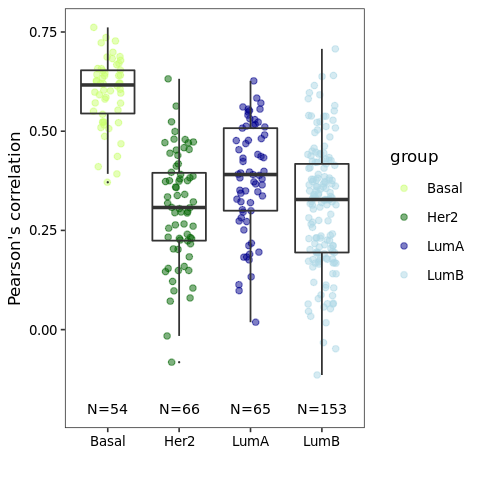

In [49]:
options(repr.plot.width = 4, repr.plot.height =4)
pl=ggplot(res_all,aes(x=group,y=value))+
geom_point(position=position_jitter(width=0.2),alpha=0.5,aes(col=group))+
geom_boxplot(fill="transparent",outlier.size = 0)+scale_color_manual(values = cols$PAM50.subtype_sc)+
ylab("Pearson's correlation")+xlab("")+stat_summary(fun.data = give.n,fun.args = c(y=-0.2), geom = "text",size=3)
pdf("cor_boxpl_var_genes.pdf",width = 4, height=4)
pl
dev.off()
pl

In [50]:
pvals

V1,V2,pval
<chr>,<chr>,<dbl>
Basal,Her2,2.724972e-18
Basal,LumB,2.003607e-22
Basal,LumA,6.411722e-15
Her2,LumB,9.268543e-01
Her2,LumA,1.963091e-03
LumB,LumA,9.498320e-04


### Explain cell type composition variability

In [40]:
obs=fread(paste0(baseDir,"/PyCache/fresh_frozen_combined_obs.tsv"))

In [41]:
cell_counts=obs[,.N,by=c('name','cell_type')]

In [42]:
cell_counts_df=dcast(cell_counts,cell_type~name,value.var = "N")
cell_counts_df[is.na(cell_counts_df)]=0

In [43]:
cell_counts_mat=as.matrix(data.frame(cell_counts_df,row.names = "cell_type",check.names = FALSE))
include_samples=colnames(cell_counts_mat)
include_samples=include_samples[!include_samples%in%row.names(annot_df[annot_df$receptors_biopsy=="NA",])]
cell_counts_mat=cell_counts_mat[,include_samples]

In [44]:
# Pearson's contingency ratio (normalization to express excess over assumption of randomnes)
#  https://econ-papers.upf.edu/papers/908.pdf  page 10
cSums=colSums(cell_counts_mat+1)
rSums=rowSums(cell_counts_mat+1)
aSum=sum(cell_counts_mat+1)
cell_counts_scale=(cell_counts_mat+1)*aSum/outer(rSums,cSums)

In [45]:
cell_counts_mat[1:5,1:5]
cell_counts_scale[1:5,1:5]

,HTAPP-211-SMP-6751,HTAPP-213-SMP-6752,HTAPP-223-SMP-6755,HTAPP-223-SMP-7537,HTAPP-225-SMP-6756
Adipocytes,0,0,0,0,484
B,0,0,2,0,0
B_plasma,0,0,366,0,31
Chondrocyte,0,0,0,0,0
Endothelial,0,0,0,0,0


,HTAPP-211-SMP-6751,HTAPP-213-SMP-6752,HTAPP-223-SMP-6755,HTAPP-223-SMP-7537,HTAPP-225-SMP-6756
Adipocytes,0.051646213,0.084815435,0.055784687,0.064002431,130.62577562
B,0.006819446,0.011199162,0.022097689,0.008450980,0.03556295
B_plasma,0.009376036,0.015397694,3.716737099,0.011619227,1.56465251
Chondrocyte,0.014019773,0.023023820,0.015143194,0.017373966,0.07311216
Endothelial,0.006056084,0.009945539,0.006541366,0.007504986,0.03158207


In [46]:
response=cell_counts_scale
vars=annot_df[include_samples,]
response_mean=t(as.matrix(colMeans(response)))
row.names(response_mean)<-"means"
response=rbind(response_mean,response)

stopifnot(colnames(response)==row.names(vars))

form <-  ~ (1|method)+(1|htapp_id)+(1|site_biopsy)+(1|receptors_biopsy)+(1|metastatic_presentation)+(1|histology_breast)+ (1|treatment_most_recent_class)

suppressMessages(varPart_cells <- fitExtractVarPartModel( log(response), form, vars))
write.table(varPart_cells,"varPart_cells.tsv", sep="\t",quote=F,row.names = F)

Warning message:
"executing %dopar% sequentially: no parallel backend registered"



Finished...
Total: 4 s


png 
  2

png 
  2

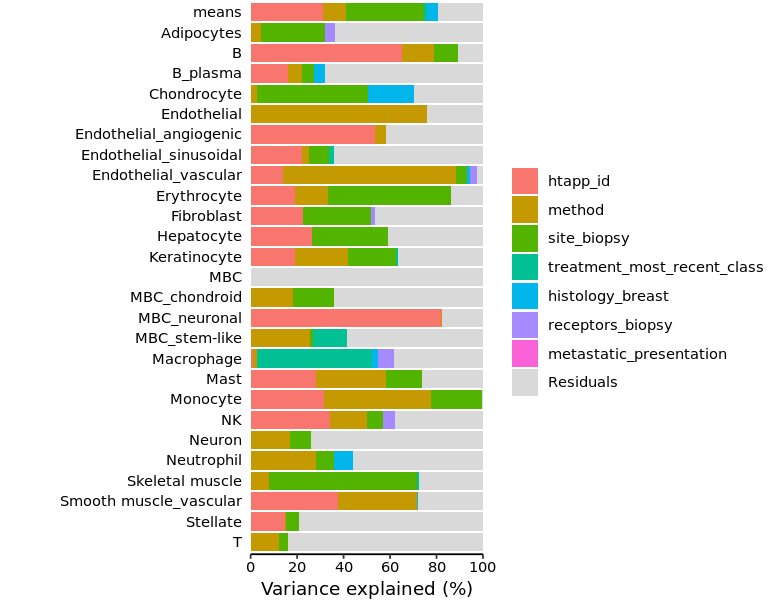

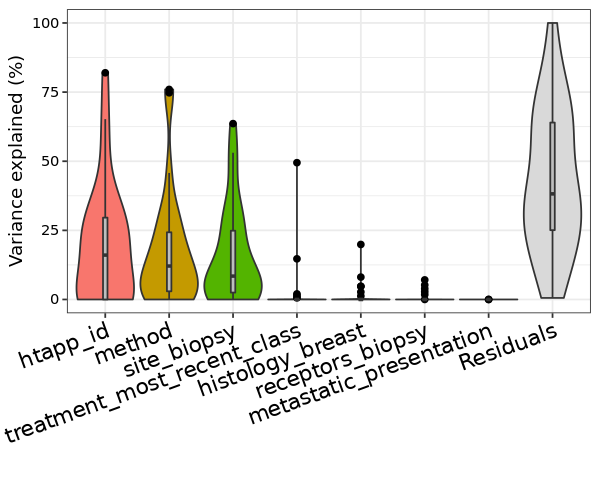

In [87]:
vp_cells <- sortCols( varPart_cells ,FUN='max')

pdf("varPart_cells_bar.pdf",width=6.5,height=5)
plotPercentBars( vp_cells)
dev.off()

pdf("varPart_cells_viol.pdf",width=5,height=4)
plotVarPart( vp_cells )
dev.off()

options(repr.plot.width = 6.5, repr.plot.height =5)
plotPercentBars( vp_cells)
options(repr.plot.width = 5, repr.plot.height =4)
plotVarPart( vp_cells )

In [52]:
names(vp_cells)

[1] "htapp_id"                    "method"                     
[3] "site_biopsy"                 "treatment_most_recent_class"
[5] "histology_breast"            "receptors_biopsy"           
[7] "metastatic_presentation"     "Residuals"

png 
  2

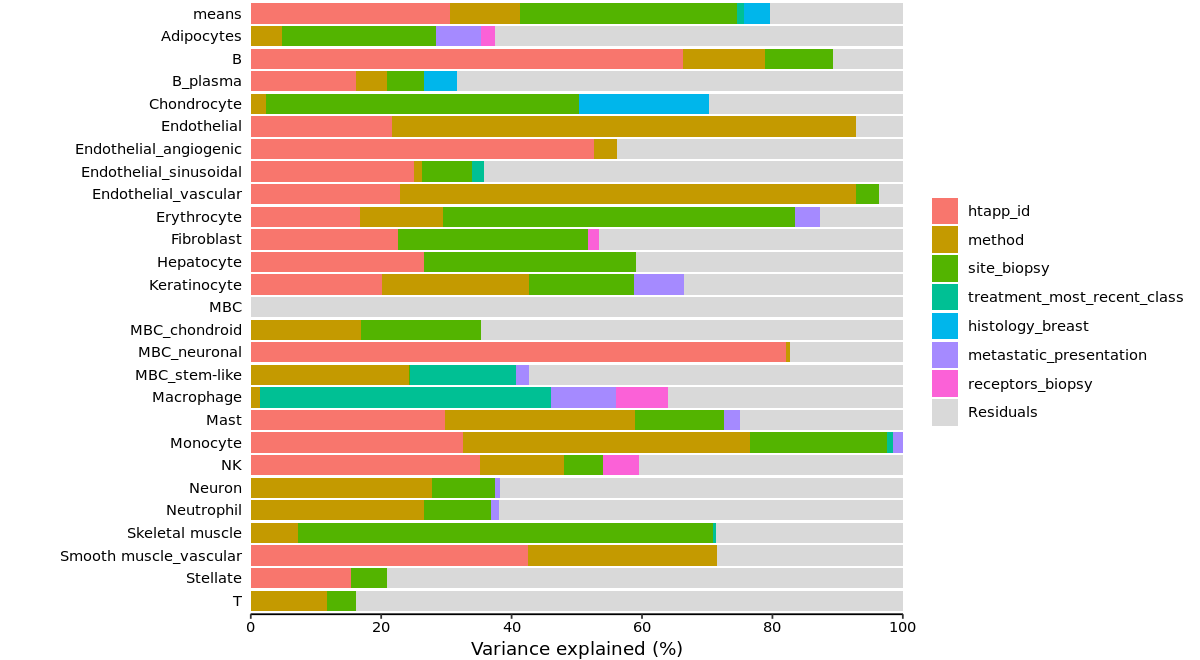

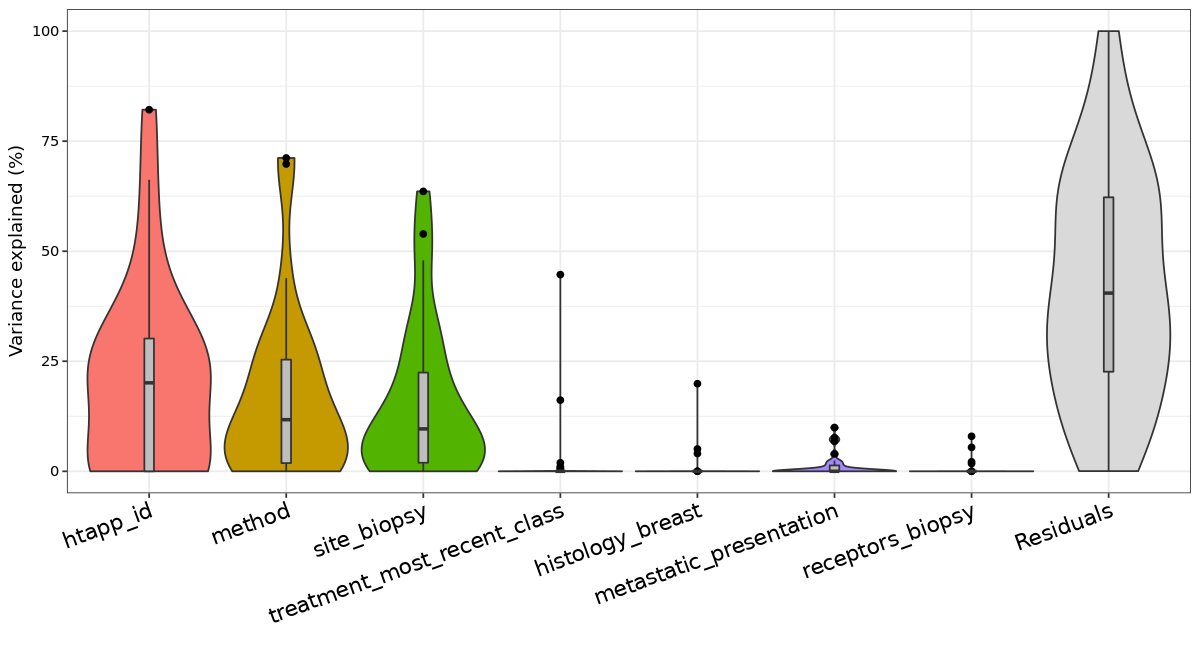

In [17]:
#before fixing sn-sc
options(repr.plot.width = 10, repr.plot.height =5.5)
vp_cells <- sortCols( varPart_cells )

pdf("varPart_cells.pdf",width=10,height=5.5)
plotPercentBars( vp_cells)
plotVarPart( vp_cells )
dev.off()

plotPercentBars( vp_cells)
plotVarPart( vp_cells )

In [65]:
plot_ctfr <-function(mat,ct,var){

    GE <- data.table( score = mat[ct,], var = annot_df[colnames(mat),var])
    
    GE[,N_var:=.N,by=var]
    GE[N_var<3,var:="other",]
    GE[,median_score:=median(score),by=var]
    GE[,var:=factor(var,levels=unique(var[order(median_score)])),]
    
    #test
#    pvals=as.data.table(t(combn(x=unique(GE$var),m=2)))
    pvals=data.table(V1=unique(GE$var))
    pvals[,pval:=wilcox.test(GE[var==V1,]$score,GE[var!=V1,]$score)$p.value,by=1:nrow(pvals)]
    pvals[,p.adjust:=p.adjust(pval,method = "fdr"),]
    
    pvals
    pl=ggplot(GE,aes(x=var,y=score))+geom_boxplot(outlier.color = "transparent")+
    geom_point(position=position_jitter(width=0.2),alpha=0.6)+ggtitle(ct)+
    geom_text(data = pvals,aes(label=signif(p.adjust,2),x=V1),y=max(GE$score)-1)+
    ylab("frequency score")+xlab("")+rotate_labels()  
}



png 
  2

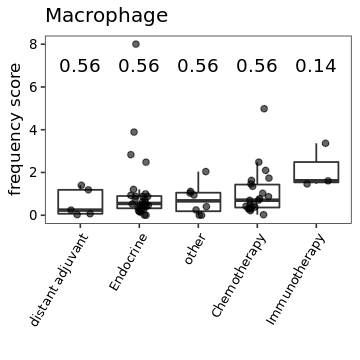

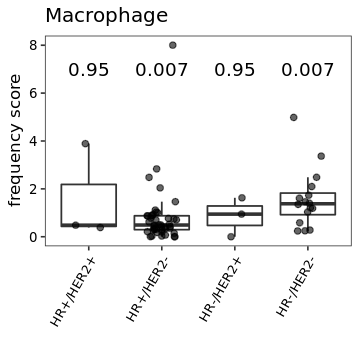

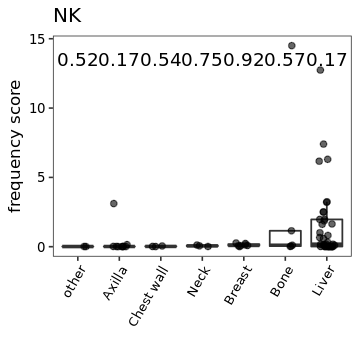

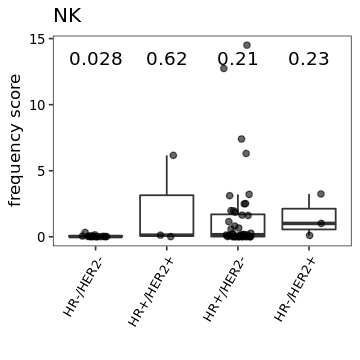

In [66]:
options(repr.plot.width = 3, repr.plot.height =3)
p1=plot_ctfr(cell_counts_scale,"Macrophage","treatment_most_recent_class")
p2=plot_ctfr(cell_counts_scale,"Macrophage","receptors_biopsy_simpl")
p3=plot_ctfr(cell_counts_scale,"NK","site_biopsy")
p4=plot_ctfr(cell_counts_scale,"NK","receptors_biopsy_simpl")
pdf("ct_compare.pdf",width=3,height=3)
p1
p2
p3
p4
dev.off()
p1
p2
p3
p4

In [67]:
pca=princomp(varPart_cells)

In [68]:
summary(pca)

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4      Comp.5
Standard deviation     0.3000328 0.2202344 0.1993859 0.11077266 0.040883436
Proportion of Variance 0.4678009 0.2520540 0.2065915 0.06376591 0.008685967
Cumulative Proportion  0.4678009 0.7198548 0.9264463 0.99021221 0.998898178
                            Comp.6       Comp.7 Comp.8
Standard deviation     0.014561094 6.313075e-08      0
Proportion of Variance 0.001101822 2.071120e-14      0
Cumulative Proportion  1.000000000 1.000000e+00      1

png 
  2

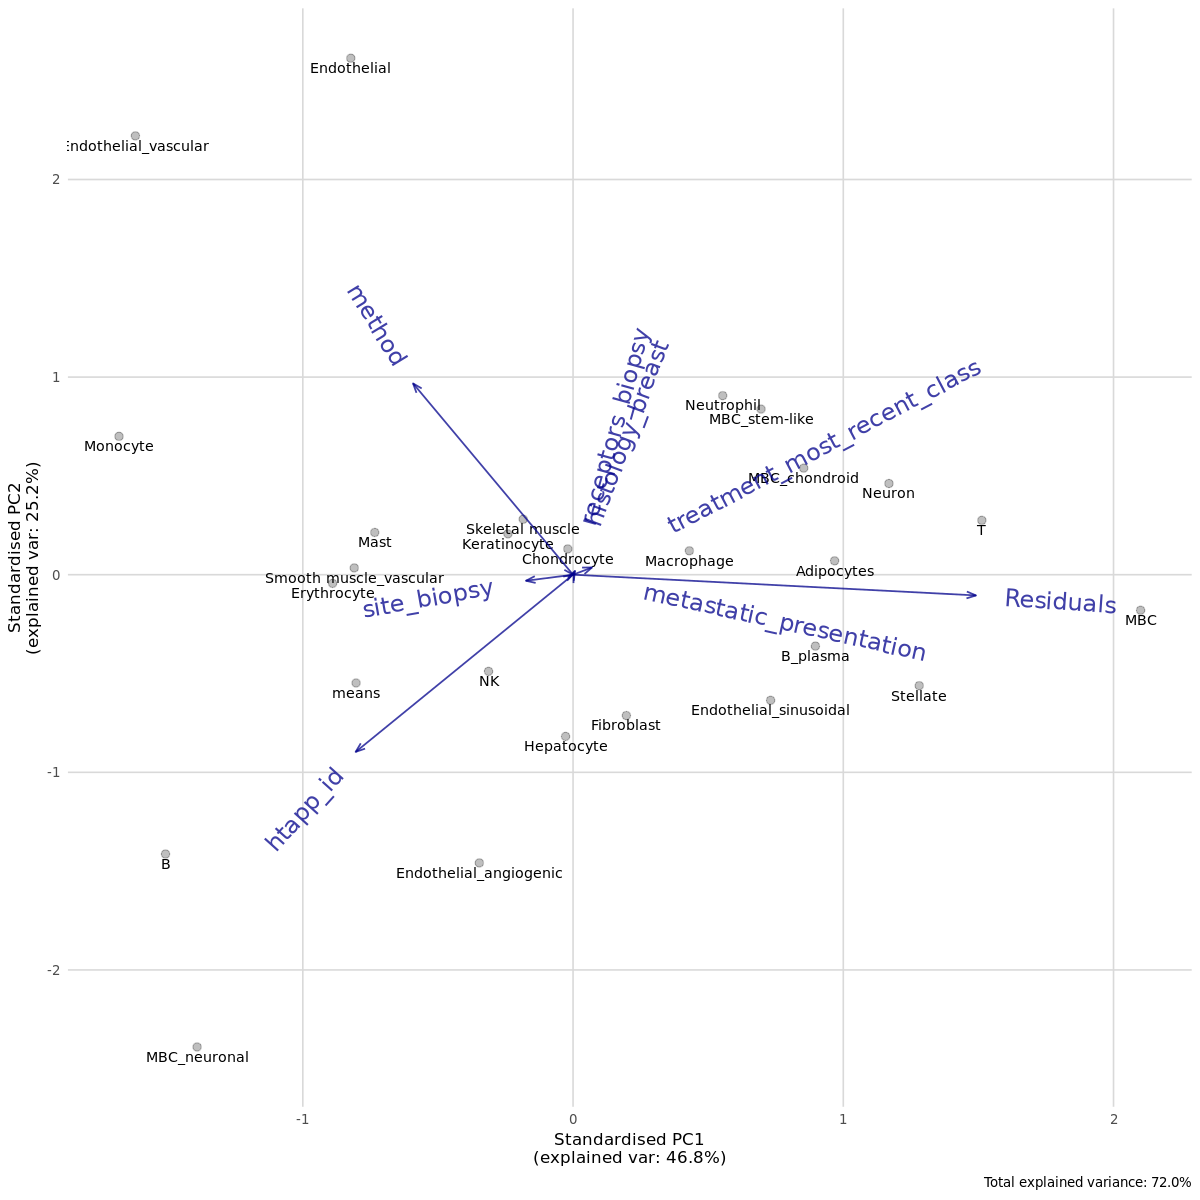

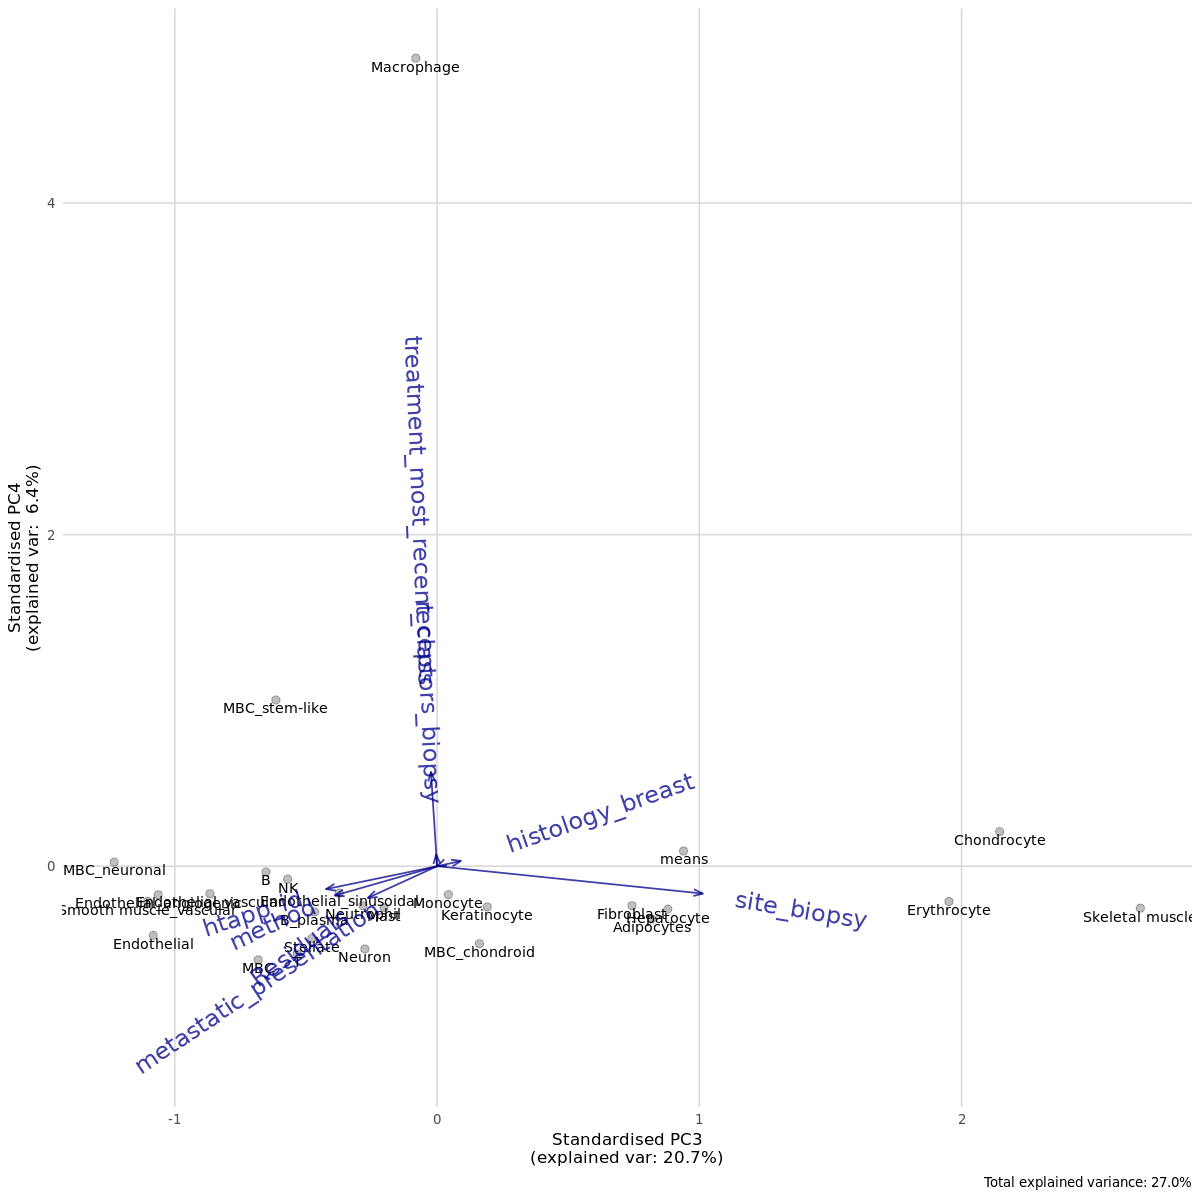

In [69]:
options(repr.plot.width = 10, repr.plot.height =10)
p1=ggplot_pca(pca,choices = c(1,2),arrows_textsize = 5,labels = rownames(varPart_cells))
p2=ggplot_pca(pca,choices = c(3,4),arrows_textsize = 5, labels = rownames(varPart_cells))

pdf("varPart_cells_pca.pdf",width = 10,height = 10)
p1
p2
dev.off()
p1
p2

### Correlate expression and cell type proportions

In [3]:
comp="_mal"
expr=fread(paste0(baseDir,"/PyCache/pseudobulk_counts",comp,".tsv"))

In [4]:
expr_long=melt(expr,value.name = 'expr',variable.name = 'name',id.vars = 'V1')

In [5]:
expr_long[,expr_norm:=log(((expr+1)/sum(expr+1))*10000),by=c('name')]

In [6]:
obs=fread(paste0(baseDir,"/PyCache/fresh_frozen_combined_obs.tsv"))

In [7]:
cell_counts=obs[,.N,by=c('name','batch','site_biopsy','cell_type','receptors_biopsy')]

In [8]:
annot=unique(cell_counts[,c('name','batch','site_biopsy','receptors_biopsy'),])

In [9]:
cell_counts_df=dcast(cell_counts,cell_type~name,value.var = "N")
cell_counts_df[is.na(cell_counts_df)]=0

In [10]:
cell_counts=melt(cell_counts_df,id.vars = 'cell_type',value.name ='N' ,variable.name = 'name')

In [11]:
cell_counts=merge(cell_counts,annot,by='name')

In [12]:
cell_counts[,frac:=N/sum(N),by=c('name')]

In [13]:
ct=c('T','NK')
cell_counts_sub=cell_counts[cell_type%in%ct]

In [14]:
cell_counts_sub=cell_counts_sub[,.(N=sum(N),frac=sum(frac)),by=c('name','batch','site_biopsy','receptors_biopsy')]

In [15]:
gene='SOX4'
expr_sub=expr_long[V1==gene]

In [16]:
ct_expr=merge(expr_sub,cell_counts_sub,by='name')

In [17]:
ct_expr[,receptor_simpl:=ifelse(receptors_biopsy%in%c("ER-/PR-/HER2-"),'TNBC','other'),]

In [32]:
sp_samp=c('HTAPP-944-SMP-7479', 'HTAPP-880-SMP-7179', 'HTAPP-878-SMP-7149', 'HTAPP-812-SMP-8239', 'HTAPP-514-SMP-6760',
 'HTAPP-982-SMP-7629', 'HTAPP-917-SMP-4531', 'HTAPP-853-SMP-4381', 'HTAPP-313-SMP-932')
ct_expr[,annot:=ifelse(name%in%sp_samp,sub("-SMP.*","",sub("HTAPP-","",name)),NA),]

In [33]:
cors=unique(ct_expr[,cor.test(expr_norm,frac,method = 'pearson'),by=c('batch')][,c("batch",'p.value','estimate'),])

Warning message:
"Removed 58 rows containing missing values (geom_text)."


png 
  2

Warning message:
"Removed 58 rows containing missing values (geom_text)."


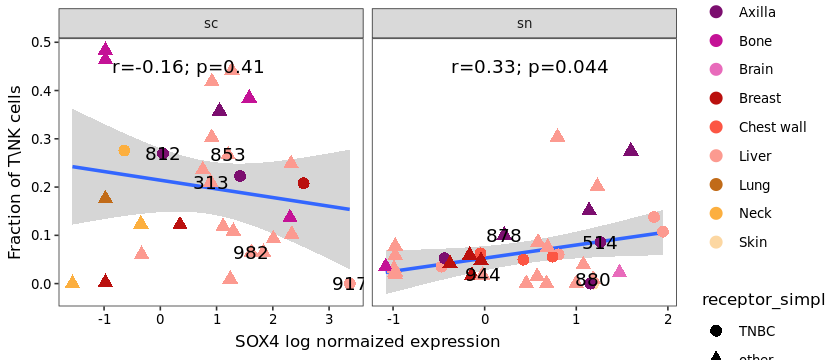

In [36]:
options(repr.plot.width = 7, repr.plot.height =3)
pl=ggplot(ct_expr,aes(x=expr_norm,y=frac))+geom_smooth(method = lm)+geom_point(size=3,aes(shape=receptor_simpl,col=site_biopsy))+
geom_text(aes(label=annot))+geom_text(data = cors,x=0.5,y=0.45,aes(label=paste0("r=",signif(estimate,2),'; p=',signif(p.value,2))))+
scale_color_manual(values = unlist(ti_colors))+facet_wrap(~batch,scale="free_x")+
ylab(paste0("Fraction of ",paste0(ct,collapse='\\')," cells"))+
xlab(paste0(gene," log normaized expression"))

pdf(paste0("cor_",gene,"_",ct[1],".pdf"),width=7,height=3)
pl
dev.off()
pl